In [1]:
import polars as pl
import numpy as np
from typing import List

def diff_expr(col: str, lag: int = 1) -> pl.Expr:
    return (pl.col(col) - pl.col(col).shift(lag)).alias(f"{col}_diff_{lag}")

def second_order_diff_expr(col: str, lag: int = 1) -> pl.Expr:
    # 二阶差分 = 一阶差分的差分
    first_diff = pl.col(col) - pl.col(col).shift(lag)
    second_diff = first_diff - first_diff.shift(lag)
    return second_diff.alias(f"{col}_second_order_diff_{lag}")

def momentum_ratio_expr(col: str, lag: int = 200) -> pl.Expr:
    # 动量比率 = x_t / x_{t-lag}
    return (pl.col(col) / (pl.col(col).shift(lag) + 1e-8)).alias(f"{col}_momentum_ratio_{lag}")

def rolling_volatility_expr(col: str, window: int) -> pl.Expr:
    return pl.col(col).rolling_std(window).alias(f"{col}_volatility_{window}")

def lag_exprs(col: str, lags: List[int]) -> List[pl.Expr]:
    return [
        pl.col(col).shift(lag).alias(f"{col}_lag_{lag}")
        for lag in lags
    ]


def cross_minus_expr(a: str, b: str) -> pl.Expr:
    return (pl.col(a) - (pl.col(b) + 1e-8)).alias(f"{a}_minus_{b}")

def cols_to_transforms(
        df: pl.DataFrame,
        exclude_cols: List[str] = None
) -> List[str]:
    if exclude_cols is None:
        exclude_cols = ['px', 'timestamp', 'timestamp_dt', 'symbol']

    if isinstance(df, pl.LazyFrame):
        cols = df.collect_schema().names()
    else:
        cols = df.columns

    cols = [
        col for col in cols
        if col not in exclude_cols and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_scaled')
        ) and col.startswith("z_")
    ]

    return cols

def batch_apply_single_exprs(
        window: int,
        lag: int,
        cols: List[str] = None
) -> List[str]:
    single_exprs = []
    # single features transformation
    for col in cols:
        single_exprs.extend([
            diff_expr(col),
            second_order_diff_expr(col),
            momentum_ratio_expr(col, lag),
            rolling_volatility_expr(col, window),
        ])
        single_exprs.extend(lag_exprs(col, [10, 20, 50, 100, 200]))

    return single_exprs

def batch_apply_multi_exprs(
        cols: List[str] = None
) -> List[str]:
    multi_exprs = []

    n = len(cols)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = cols[i], cols[j]
            multi_exprs.extend([
                cross_minus_expr(a, b),
            ])

    return multi_exprs

def batch_apply_transforms(
        df_to_transforms: pl.DataFrame,
        window: int,
        lag: int,
        exclude_cols: List[str] = None
) -> pl.DataFrame:
    base_cols = cols_to_transforms(df_to_transforms, exclude_cols)
   
    single_exprs = batch_apply_single_exprs(window, lag, base_cols)
    multi_exprs = batch_apply_multi_exprs(base_cols)

    exprs = single_exprs + multi_exprs
    return df_to_transforms.with_columns(exprs)



In [2]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
    origin_input_df: pl.DataFrame,
    ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime("ms")).alias(f"{ts_col}_dt")  # 注意这里加了 "ms"
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs

def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .tanh()
        .rolling_mean(window)
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_z_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        z_score_expr(
            col=column,
            scaled_col=f"{column}_zd",
            window=window
        ) for column in columns_to_normalize
    ]) 

def z_score_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
            (pl.col(col) - pl.col(col)
             .rolling_mean(window, min_samples=1)
             .fill_null(strategy="zero"))
            / (pl.col(col)
               .rolling_std(window, min_samples=1)
               .fill_nan(0) + 1e-6)
    ).fill_null(0).clip(-2.0, 2.0).alias(scaled_col)


def rolling_mean_smooth(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_smooth = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_smooth
    ])

def rolling_mean_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window)
        .fill_null(strategy="zero")  # 或 strategy="forward" 也行
        .alias(scaled_col)
    )


def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and (col.startswith("z_") or col.startswith("raw_")) 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [3]:
symbol = "dogeusdt"
symbol.upper()
threshold = "0.002"
feat_cal_window = "500"
file = symbol + "_factors_threshold" + threshold + "_rolling" + feat_cal_window + ".csv"
path = "C:/quant/data/binance_resampled_data/" + file
origin_df = pl.read_csv(path)
# origin_df = pl.read_parquet("C:/quant/data/data_test/ethusdt_thresh0.002_hybrid.parquet")

# # 先把那两列单独 shift
# shifted_cols = origin_df.select([
#     pl.col("raw_factor_buy_sell_vlm_diff").shift(-5).alias("raw_factor_buy_sell_vlm_diff_shifted"),
#     pl.col("z_factor_buy_sell_vlm_diff").shift(-5).alias("z_factor_buy_sell_vlm_diff_shifted"),
# ])

# 删除原来的两列
# origin_df = origin_df.drop([ "z_factor_buy_sell_vlm_diff"])

# # 合并回去（按顺序拼接）
# origin_df = origin_df.with_columns([
#     shifted_cols["raw_factor_buy_sell_vlm_diff_shifted"],
#     shifted_cols["z_factor_buy_sell_vlm_diff_shifted"]
# ])
feat_trans_window = 350
feat_trans_lag = 50
feat_norm_window = 200
print(origin_df)
step = 150

origin_df = origin_df.with_columns([
    future_return_expr("px", step),
])
print(origin_df)

origin_df = batch_apply_transforms(origin_df, feat_trans_window, feat_trans_lag)
origin_df = rolling_z_normalize(origin_df, feat_norm_window)
origin_df = rolling_mean_tanh_normalize(origin_df, feat_norm_window)
print(origin_df)
stds = origin_df.select([
    pl.col(col).std().alias(col) for col in origin_df.columns if origin_df[col].dtype in (pl.Float64, pl.Int64)
])
zero_std_cols = [col for col in stds.columns if stds[0, col] == 0.0]
print(zero_std_cols)
origin_df = origin_df.drop(zero_std_cols)
print(origin_df[f"future_return_{step}"])


shape: (39_302, 112)
┌───────────────┬─────────┬─────────────┬─────────────┬───┬─────────────────────┬─────────────────────┬─────────────────────┬─────────────────────┐
│ timestamp     ┆ px      ┆ sum_buy_sz  ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_t ┆ z_factor_order_sent ┆ z_factor_oi_momentu ┆ z_factor_oi_momentu │
│ ---           ┆ ---     ┆ ---         ┆ ---         ┆   ┆ rend_confir…        ┆ iment_diver…        ┆ m_punch             ┆ m_long_term…        │
│ i64           ┆ f64     ┆ f64         ┆ f64         ┆   ┆ ---                 ┆ ---                 ┆ ---                 ┆ ---                 │
│               ┆         ┆             ┆             ┆   ┆ f64                 ┆ f64                 ┆ f64                 ┆ f64                 │
╞═══════════════╪═════════╪═════════════╪═════════════╪═══╪═════════════════════╪═════════════════════╪═════════════════════╪═════════════════════╡
│ 1744021704847 ┆ 0.1396  ┆ 1.268191e6  ┆ 608442.0    ┆ … ┆ 1.143627            ┆ -0.062711

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.mixture import GaussianMixture
from sklearn.utils.class_weight import compute_sample_weight

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import LabelEncoder
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# pdf = origin_df.to_pandas()
# # pdf["timestamp"] = pd.to_datetime(pdf["timestamp"], unit="ms")

# # 计算百分比变化（return）
# pdf["px_pct"] = pdf["px"].pct_change()

# # 绘图
# plt.figure(figsize=(8, 4))
# plt.hist(pdf["px_pct"].dropna() * 100, bins=50, color="orange", edgecolor="k")
# plt.title("Distribution of Percentage Price Change (px.pct_change())")
# plt.xlabel("Price Change (%)")
# plt.ylabel("Frequency")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [6]:
def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, std_array=None, n=700, m=-1, alpha=1):
    # 截取最后 n 行
    y_test_slice = y_test[n:m]
    y_test_binary_slice = y_test_binary[n:m]
    y_pred_prob_slice = y_pred_prob[n:m]
    px_slice = px[n:m]
    
    if std_array is not None:
        std_slice = std_array[n:m]
    else:
        std_slice = None

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # # 原始收益
    # ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    # ax1.set_ylabel("Original Future Returns", color='gray')
    # ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=5, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:blue', linestyle='--', alpha=0.6)

    # 加上下轨线
    if std_slice is not None:
        ax4.plot(time_index, px_slice + alpha * std_slice, label="Price + std", color='tab:gray', linestyle=':', alpha=0.4)
        ax4.plot(time_index, px_slice - alpha * std_slice, label="Price - std", color='tab:gray', linestyle=':', alpha=0.4)

    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.2,                  
    upper_thresh=0.8,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [8]:
from sklearn.mixture import GaussianMixture
import numpy as np

def gmm_label_binarize(y_train, y_val=None, y_test=None, verbose=True, random_state=42):
    """
    用 GMM 对收益率进行聚类，然后按均值高低映射为上涨(1)/下跌(0)标签。
    
    参数:
        y_train, y_val, y_test: Series 或 ndarray
        verbose: 是否打印详细映射信息
    返回:
        y_train_binary, y_val_binary, y_test_binary, gmm_model
    """
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np = np.asarray(y_val).reshape(-1, 1) if y_val is not None else None
    y_test_np = np.asarray(y_test).reshape(-1, 1) if y_test is not None else None

    # GMM 拟合
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    gmm.fit(y_train_np)

    means = gmm.means_.flatten()
    upward_label = np.argmax(means)
    downward_label = np.argmin(means)

    if verbose:
        print(f"GMM 分量均值: {means}")
        print(f"上涨标签: {upward_label}, 下跌标签: {downward_label}")

    # 标签转换函数
    def transform_labels(y_np):
        raw = gmm.predict(y_np)
        binary = (raw == upward_label).astype(int)
        return binary, raw

    y_train_binary, train_raw = transform_labels(y_train_np)
    y_val_binary, val_raw = transform_labels(y_val_np) if y_val_np is not None else (None, None)
    y_test_binary, test_raw = transform_labels(y_test_np) if y_test_np is not None else (None, None)

    if verbose:
        print("\n--- GMM 原始标签 => 最终二元标签映射 ---")
        for label in [0, 1]:
            print(f"GMM 内部标签 {label} (均值: {means[label]:.6f}) => 二元标签: {1 if label == upward_label else 0}")

        print("\n--- 示例标签 ---")
        print("训练集原始收益:", y_train_np[:10].flatten())
        print("训练集GMM标签:", train_raw[:10])
        print("训练集二元标签:", y_train_binary[:10])

        if y_test_binary is not None:
            print("\n测试集原始收益:", y_test_np[:10].flatten())
            print("测试集GMM标签:", test_raw[:10])
            print("测试集二元标签:", y_test_binary[:10])

    return y_train_binary, y_val_binary, y_test_binary, gmm


In [9]:
# import polars as pl
# import numpy as np
# from tqdm import tqdm

# rolling_window = 20
# alpha = 5

# a_df = (
#     origin_df
#     .with_columns([
#         pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
#     ])
# )

# def label_by_future_std(px: np.ndarray, std: np.ndarray) -> np.ndarray:
#     n = len(px)
#     labels = np.full(n, -1)  # 初始化为 -1（未触发）

#     for i in tqdm(range(n), desc="Labeling by future std"):
#         anchor_price = px[i]
#         for j in range(i + 1, n):
#             upper_bound = anchor_price + alpha * std[j]
#             lower_bound = anchor_price - alpha * std[j]
#             if px[j] >= upper_bound:
#                 labels[i] = 1
#                 break
#             elif px[j] <= lower_bound:
#                 labels[i] = 0
#                 break

#             else:
#                 labels[i] = -1

#     return labels

# px_np = a_df["px"].to_numpy()
# std_np = a_df["rolling_std"].to_numpy()

# labels_np = label_by_future_std(px_np, std_np)

# a_df = a_df.with_columns(pl.Series("future_std_label", labels_np))
# print(a_df)
# a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
# a_df_filtered = clean_df_drop_nulls(a_df_filtered)
# print(a_df_filtered)

# weekly_dataframes = split_df_by_week(a_df_filtered)
# print("num weekly dfs: ", len(weekly_dataframes))

In [10]:
import polars as pl
import numpy as np
from tqdm import tqdm

# //////////////////////////////
rolling_window = 175
alpha = 5

a_df = origin_df.with_columns([
    pl.col("px").rolling_std(window_size=rolling_window).alias("rolling_std"),
])

def label_by_future_std_with_duration_and_bars(px: np.ndarray, std: np.ndarray, ts: np.ndarray):
    n = len(px)
    labels = np.full(n, -1, dtype=np.int8)
    durations = np.full(n, -1, dtype=np.int64)  # 微秒差
    bar_counts = np.full(n, -1, dtype=np.int32) # bar 数

    for i in tqdm(range(n), desc="Labeling by future std"):
        anchor_price = px[i]
        anchor_ts = ts[i]

        for j in range(i + 1, n):
            upper_bound = anchor_price + alpha * std[j]
            lower_bound = anchor_price - alpha * std[j]

            if px[j] >= upper_bound:
                labels[i] = 1
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break
            elif px[j] <= lower_bound:
                labels[i] = 0
                durations[i] = ts[j] - anchor_ts
                bar_counts[i] = j - i
                break

    return labels, durations, bar_counts


px_np = a_df["px"].to_numpy()
std_np = a_df["rolling_std"].to_numpy()
ts_np = a_df["timestamp"].to_numpy()

labels_np, durations_np, bar_counts_np = label_by_future_std_with_duration_and_bars(px_np, std_np, ts_np)

a_df = a_df.with_columns([
    pl.Series("future_std_label", labels_np),
    pl.Series("label_duration_us", durations_np),
    pl.Series("label_bar_count", bar_counts_np),
])

a_df_filtered = a_df.filter(pl.col("future_std_label") >= 0)
a_df_filtered = clean_df_drop_nulls(a_df_filtered)
print(a_df_filtered)

weekly_dataframes = split_df_by_week(a_df_filtered)
print("num weekly dfs:", len(weekly_dataframes))

Labeling by future std: 100%|█████████████████████████████████████████████████████████████████████████████| 39302/39302 [00:07<00:00, 5322.02it/s]


各列空值数量：
z_factor_oi_change_diff_1                                                                     1
z_factor_oi_change_second_order_diff_1                                                        2
z_factor_oi_change_momentum_ratio_50                                                         50
z_factor_oi_change_volatility_350                                                           349
z_factor_oi_change_lag_10                                                                    10
                                                                                           ... 
z_factor_momentum_trend_confirm_minus_z_factor_oi_momentum_long_term_punch_zd_scaled        398
z_factor_order_sentiment_divergence_minus_z_factor_oi_momentum_punch_zd_scaled              398
z_factor_order_sentiment_divergence_minus_z_factor_oi_momentum_long_term_punch_zd_scaled    398
z_factor_oi_momentum_punch_minus_z_factor_oi_momentum_long_term_punch_zd_scaled             398
rolling_std                     

In [11]:
mean_duration = a_df_filtered.select(pl.col("label_duration_us").mean()).item()
mean_bar_count = a_df_filtered.select(pl.col("label_bar_count").mean()).item()
mean_ret = a_df_filtered.select(pl.col(f"future_return_{step}").mean()).item()
mean_std = a_df_filtered.select(pl.col("rolling_std").mean()).item()

print(a_df_filtered[f"future_return_{step}"])
print(mean_ret)
print(f"Mean duration: {mean_duration/1_000}")
print(f"Mean bar count: {mean_bar_count}")
print(mean_std)
print(mean_std * alpha)
print((mean_std * alpha) / a_df_filtered.select("px").tail(1).item())
print((mean_std) / a_df_filtered.select("px").tail(1).item())


shape: (38_173,)
Series: 'future_return_150' [f64]
[
	-0.012737
	-0.017035
	-0.012805
	-0.012698
	-0.008573
	…
	0.024421
	0.028617
	0.028616
	0.028736
	0.028737
]
0.0009325518671254759
Mean duration: 103140.74150365443
Mean bar count: 487.52083933670394
0.002039559678622178
0.010197798393110889
0.06029918633580232
0.012059837267160466


In [12]:
# print(
#     a_df_filtered
#     .select(pl.col("future_std_label").value_counts(sort=True))
# )


In [13]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime

def save_tabnet_checkpoint(
    model,
    symbol,
    base_save_dir: str,
    model_params: dict,
    feature_names: list[str],
    training_meta: dict,
    unique_id: str = None, 
):
    if unique_id is None:
        timestamp = str(datetime.now().strftime("%Y-%m-%d_%H-%M"))
        save_dir = os.path.join(base_save_dir, f"{symbol}_{timestamp}")
    else:
        save_dir = os.path.join(base_save_dir, f"{symbol}_{unique_id}")

    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, "tabnet_model")
    model.save_model(model_path)

    config_path = os.path.join(save_dir, "model_metadata.json")
    with open(config_path, "w") as f:
        json.dump({
            "model_params": model_params,
            "meta_info": training_meta,
        }, f, indent=4)

    aux_path = os.path.join(save_dir, "auxiliary.pkl")
    with open(aux_path, "wb") as f:
        pickle.dump({
            "feature_names": feature_names,
        }, f)

    print(f"model and meta info saved to {save_dir}")


Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 14:37:36.494000 to 2025-04-27 23:58:11.894000
Val: 2025-04-28 00:03:47.419000 to 2025-05-04 23:43:07.376000
Test: 2025-05-05 00:01:40.038000 to 2025-05-11 23:57:23.472000
GMM 分量均值: [ 0.02018453 -0.00995897]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.020185) => 二元标签: 1
GMM 内部标签 1 (均值: -0.009959) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.01273713 -0.01703508 -0.01280488 -0.01269777 -0.00857318 -0.01283096
 -0.00877551 -0.00463531 -0.00040984 -0.000409  ]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.00509547 -0.00516462 -0.00919527 -0.01320942 -0.01738217 -0.01338477
 -0.01341577 -0.01338477 -0.01341577 -0.00941025]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[0.84809337 0.84809337 0.84809337 ... 1.21819811 0.84809337 1.21819811]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01595 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.22141 | val_0_balanced_accuracy: 0.42755 |  0:00:02s
epoch 10 | loss: 0.19287 | val_0_balanced_accuracy: 0.41738 |  0:00:05s
epoch 15 | loss: 0.1838  | val_0_balanced_accuracy: 0.40407 |  0:00:07s
epoch 20 | loss: 0.17137 | val_0_balanced_accuracy: 0.41246 |  0:00:09s
epoch 25 | loss: 0.16528 | val_0_balanced_accuracy: 0.42787 |  0:00:11s
epoch 30 | loss: 0.15185 | val_0_balanced_accuracy: 0.37823 |  0:00:14s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6946
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.4548
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


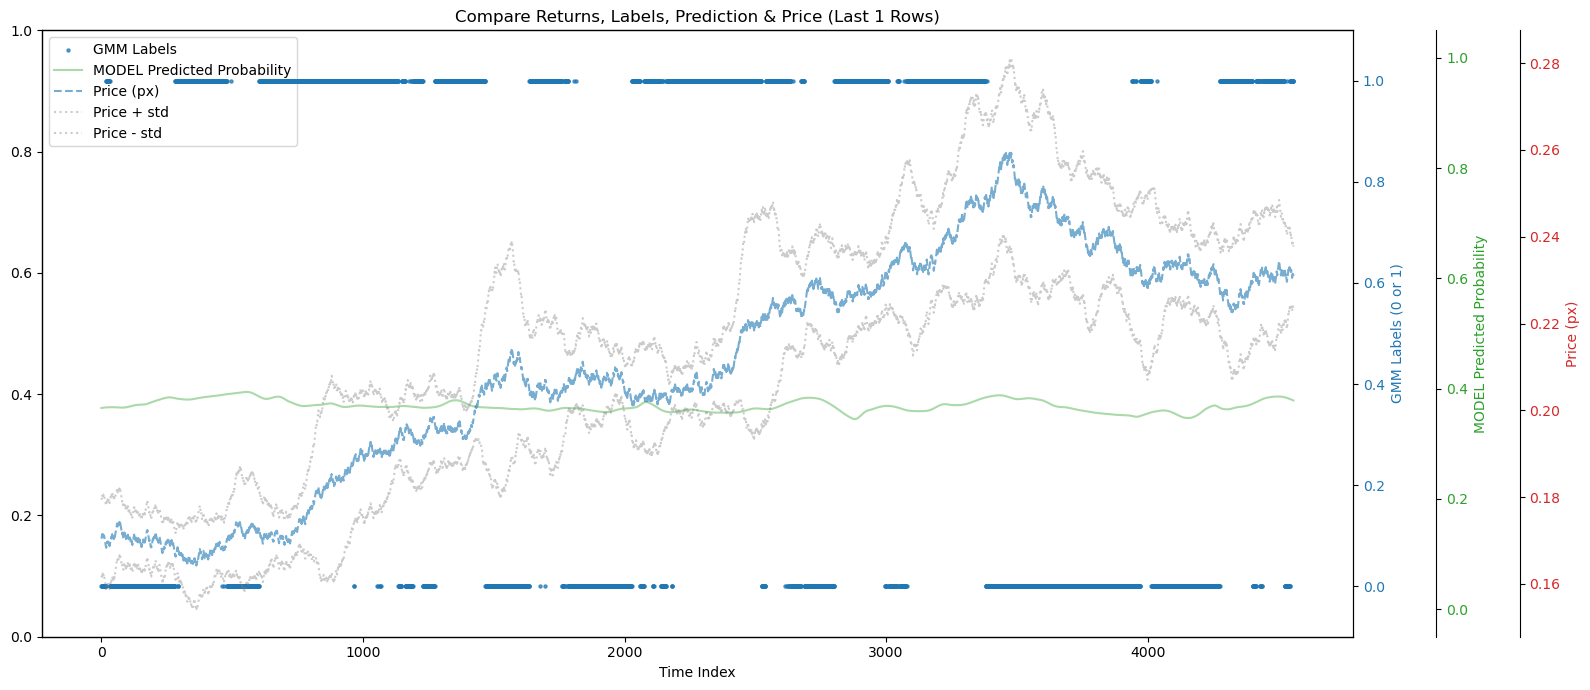

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01595 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.22141 | val_0_balanced_accuracy: 0.42755 |  0:00:02s
epoch 10 | loss: 0.19287 | val_0_balanced_accuracy: 0.41738 |  0:00:05s
epoch 15 | loss: 0.1838  | val_0_balanced_accuracy: 0.40407 |  0:00:07s
epoch 20 | loss: 0.17137 | val_0_balanced_accuracy: 0.41246 |  0:00:09s
epoch 25 | loss: 0.16528 | val_0_balanced_accuracy: 0.42787 |  0:00:11s
epoch 30 | loss: 0.15185 | val_0_balanced_accuracy: 0.37823 |  0:00:13s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6946
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4548
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


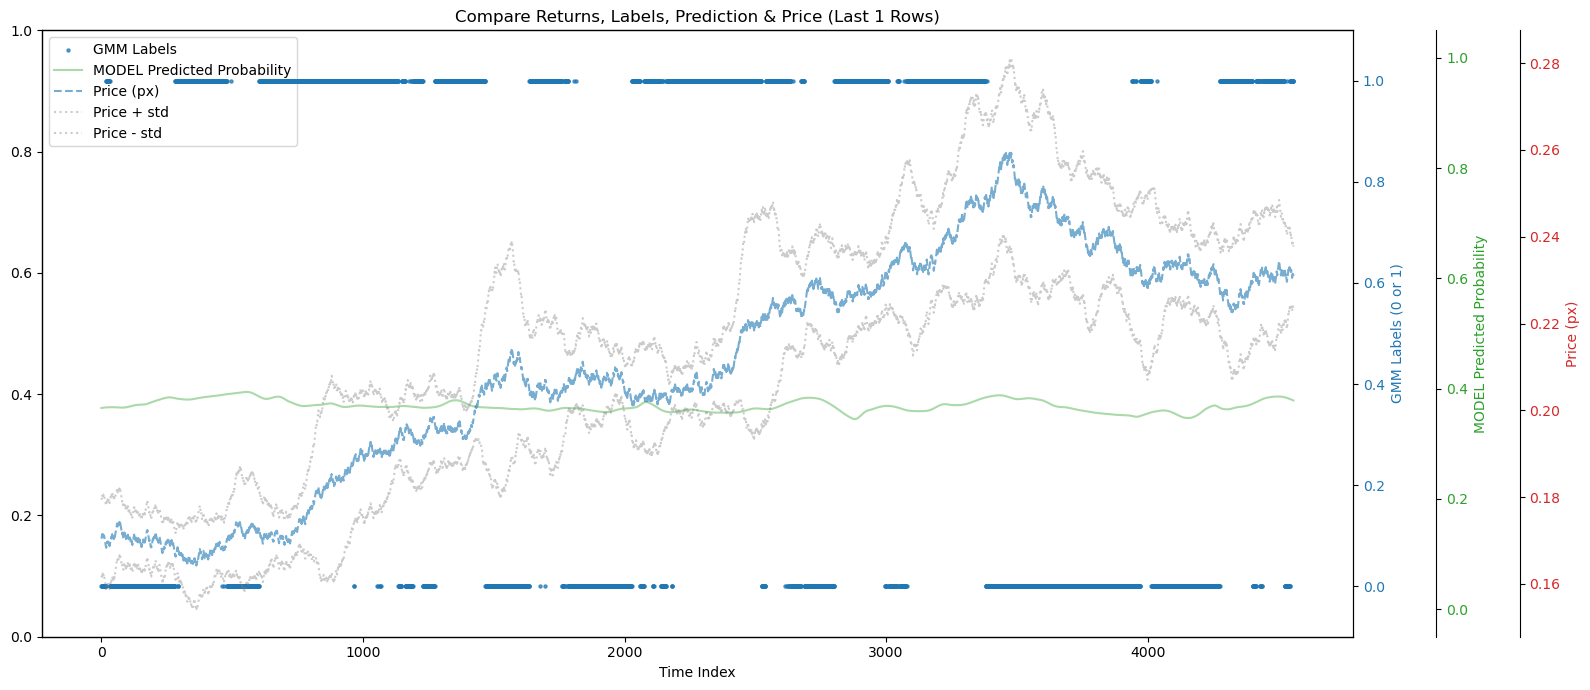

Test Week 3 Evaluation Completed
Fold 1: Train 1~3, Val 4, Test 5
Train: 2025-04-14 00:03:32.085000 to 2025-05-04 23:43:07.376000
Val: 2025-05-05 00:01:40.038000 to 2025-05-11 23:57:23.472000
Test: 2025-05-12 00:00:16.471000 to 2025-05-18 23:59:03.907000
GMM 分量均值: [ 0.02370175 -0.01143167]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.023702) => 二元标签: 1
GMM 内部标签 1 (均值: -0.011432) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [ 0.01099171  0.0151366   0.0151674   0.01107556  0.01105312  0.00686317
  0.00275196  0.00274641  0.00274089 -0.00127652]
训练集GMM标签: [0 0 0 0 0 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 0 0 0 0 0]

测试集原始收益: [0.01885324 0.01890131 0.01472868 0.01061589 0.01472868 0.01461109
 0.01464129 0.01052903 0.01055069 0.0104001 ]
测试集GMM标签: [0 0 0 0 0 0 0 1 1 1]
测试集二元标签: [1 1 1 1 1 1 1 0 0 0]
[1.58258824 1.58258824 1.58258824 ... 0.73092806 0.73092806 0.73092806]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.19554 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.18865 | val_0_balanced_accuracy: 0.41903 |  0:00:02s
epoch 10 | loss: 0.14448 | val_0_balanced_accuracy: 0.4395  |  0:00:04s
epoch 15 | loss: 0.13754 | val_0_balanced_accuracy: 0.45158 |  0:00:06s
epoch 20 | loss: 0.14347 | val_0_balanced_accuracy: 0.4808  |  0:00:08s
epoch 25 | loss: 0.12342 | val_0_balanced_accuracy: 0.47084 |  0:00:10s
epoch 30 | loss: 0.11918 | val_0_balanced_accuracy: 0.5255  |  0:00:11s
epoch 35 | loss: 0.11529 | val_0_balanced_accuracy: 0.53413 |  0:00:13s
epoch 40 | loss: 0.11471 | val_0_balanced_accuracy: 0.58307 |  0:00:15s
epoch 45 | loss: 0.11245 | val_0_balanced_accuracy: 0.60223 |  0:00:17s
epoch 50 | loss: 0.10523 | val_0_balanced_accuracy: 0.55029 |  0:00:18s
epoch 55 | loss: 0.10707 | val_0_balanced_accuracy: 0.53877 |  0:00:20s
epoch 60 | loss: 0.10534 | val_0_balanced_accuracy: 0.55012 |  0:00:22s
epoch 65 | loss: 0.10589 | val_0_balanced_accuracy: 0.55541 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6011
✅ 自信预测准确率: 0.6833 (阈值 0.2-0.8)
📈 出手率: 47.85%

🧮 自信预测混淆矩阵:
[[1105  246]
 [ 445  386]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      1351
           1       0.61      0.46      0.53       831

    accuracy                           0.68      2182
   macro avg       0.66      0.64      0.64      2182
weighted avg       0.67      0.68      0.67      2182


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5306
✅ 自信预测准确率: 0.5888 (阈值 0.2-0.8)
📈 出手率: 42.49%

🧮 自信预测混淆矩阵:
[[1273  446]
 [ 594  216]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1719
           1       0.33      0.27      0.29       810

    accuracy                           0.59      2529
   macro avg       0.50      0.50      0.50      2529
weighted avg       0.57      0.59      0.58      2529



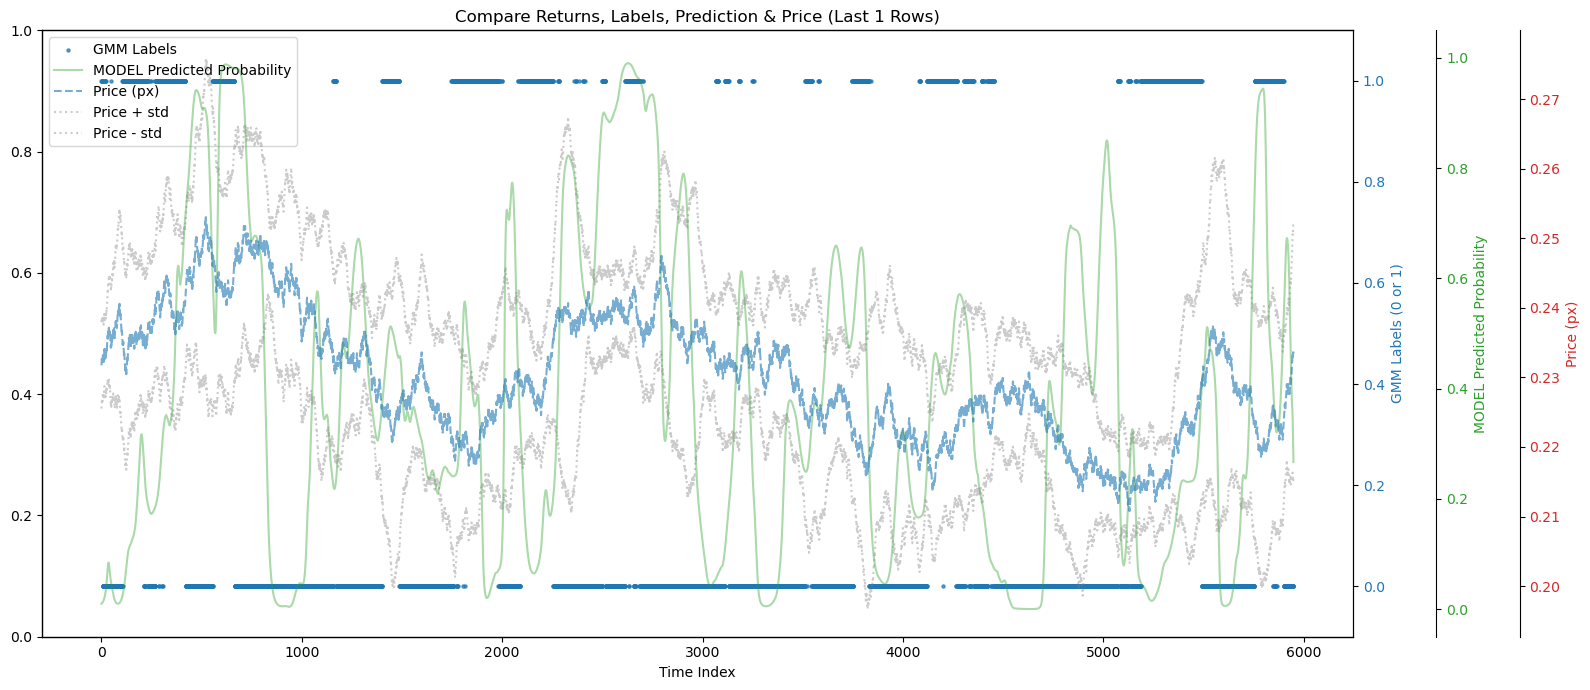

epoch 0  | loss: 0.66464 | val_0_balanced_accuracy: 0.5163  |  0:00:00s
epoch 5  | loss: 0.18092 | val_0_balanced_accuracy: 0.50599 |  0:00:02s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.53447


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5428
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3226
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


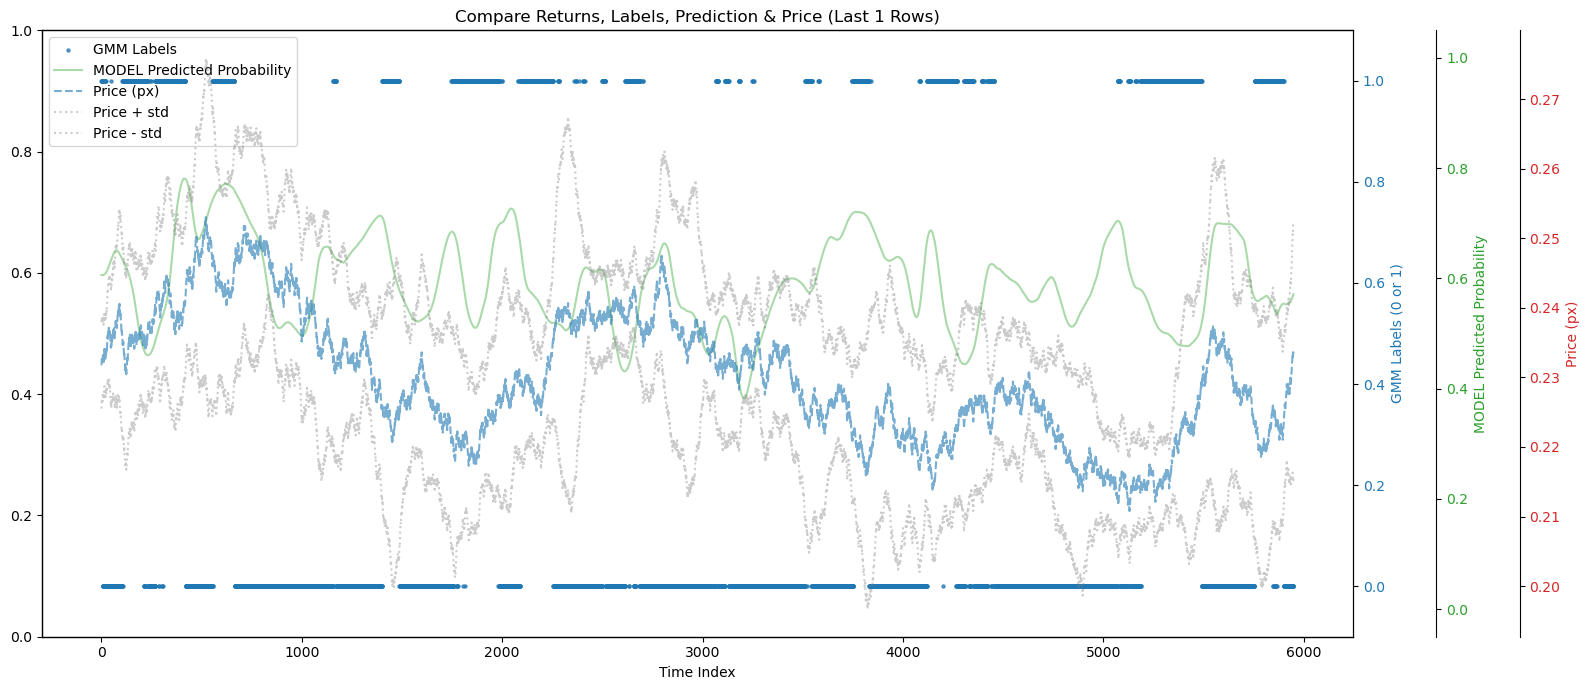

Test Week 4 Evaluation Completed
Fold 2: Train 2~4, Val 5, Test 6
Train: 2025-04-21 00:05:07.180000 to 2025-05-11 23:57:23.472000
Val: 2025-05-12 00:00:16.471000 to 2025-05-18 23:59:03.907000
Test: 2025-05-19 00:00:36.761000 to 2025-05-25 23:57:02.353000
GMM 分量均值: [-0.01135443  0.0271156 ]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.011354) => 二元标签: 0
GMM 内部标签 1 (均值: 0.027116) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.0396116  0.03535905 0.03528432 0.03527607 0.03099292 0.02672776
 0.02254541 0.01831664 0.01834282 0.01413874]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.04938748 -0.04940126 -0.0494151  -0.04930609 -0.04543295 -0.04930609
 -0.04929032 -0.04931754 -0.05315913 -0.05702561]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.10942721 1.10942721 1.10942721 ... 1.10942721 1.10942721 1.10942721]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94869 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.19055 | val_0_balanced_accuracy: 0.48369 |  0:00:03s
epoch 10 | loss: 0.14487 | val_0_balanced_accuracy: 0.52993 |  0:00:05s
epoch 15 | loss: 0.13809 | val_0_balanced_accuracy: 0.54373 |  0:00:08s
epoch 20 | loss: 0.12769 | val_0_balanced_accuracy: 0.54684 |  0:00:10s
epoch 25 | loss: 0.11458 | val_0_balanced_accuracy: 0.50759 |  0:00:13s
epoch 30 | loss: 0.11864 | val_0_balanced_accuracy: 0.5312  |  0:00:15s
epoch 35 | loss: 0.12045 | val_0_balanced_accuracy: 0.53207 |  0:00:18s
epoch 40 | loss: 0.11837 | val_0_balanced_accuracy: 0.5865  |  0:00:20s

Early stopping occurred at epoch 43 with best_epoch = 13 and best_val_0_balanced_accuracy = 0.59221


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6280
✅ 自信预测准确率: 0.6254 (阈值 0.2-0.8)
📈 出手率: 26.19%

🧮 自信预测混淆矩阵:
[[762 430]
 [154 213]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.83      0.64      0.72      1192
           1       0.33      0.58      0.42       367

    accuracy                           0.63      1559
   macro avg       0.58      0.61      0.57      1559
weighted avg       0.71      0.63      0.65      1559


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5547
✅ 自信预测准确率: 0.5475 (阈值 0.2-0.8)
📈 出手率: 55.39%

🧮 自信预测混淆矩阵:
[[968 311]
 [647 191]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.60      0.76      0.67      1279
           1       0.38      0.23      0.29       838

    accuracy                           0.55      2117
   macro avg       0.49      0.49      0.48      2117
weighted avg       0.51      0.55      0.52      2117



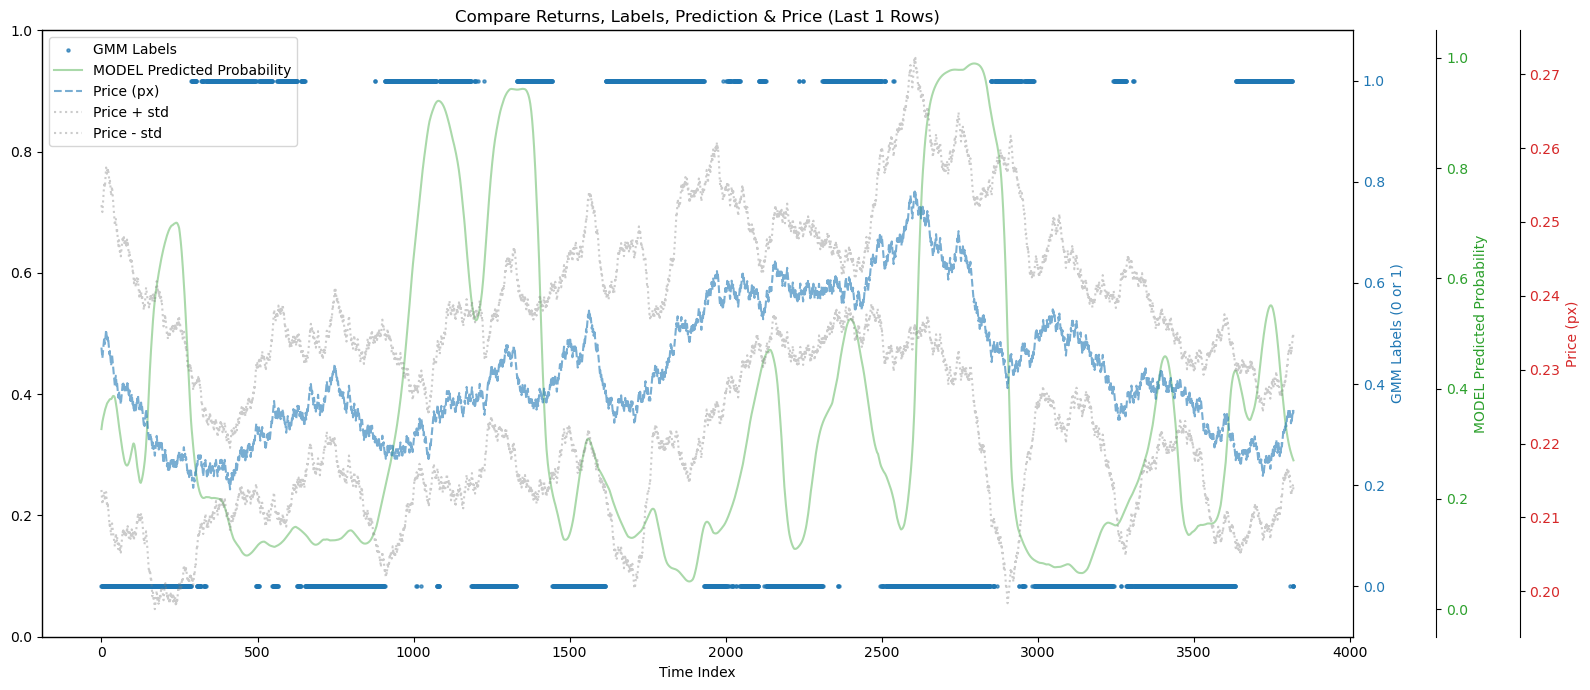

epoch 0  | loss: 0.39642 | val_0_balanced_accuracy: 0.44337 |  0:00:00s
epoch 5  | loss: 0.15666 | val_0_balanced_accuracy: 0.58047 |  0:00:03s

Early stopping occurred at epoch 8 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.59994


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5403
✅ 自信预测准确率: 0.4947 (阈值 0.2-0.8)
📈 出手率: 33.32%

🧮 自信预测混淆矩阵:
[[662 970]
 [ 32 319]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.95      0.41      0.57      1632
           1       0.25      0.91      0.39       351

    accuracy                           0.49      1983
   macro avg       0.60      0.66      0.48      1983
weighted avg       0.83      0.49      0.54      1983


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5222
✅ 自信预测准确率: 0.7171 (阈值 0.2-0.8)
📈 出手率: 20.07%

🧮 自信预测混淆矩阵:
[[126 123]
 [ 94 424]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       249
           1       0.78      0.82      0.80       518

    accuracy                           0.72       767
   macro avg       0.67      0.66      0.67       767
weighted avg       0.71      0.72      0.71       767



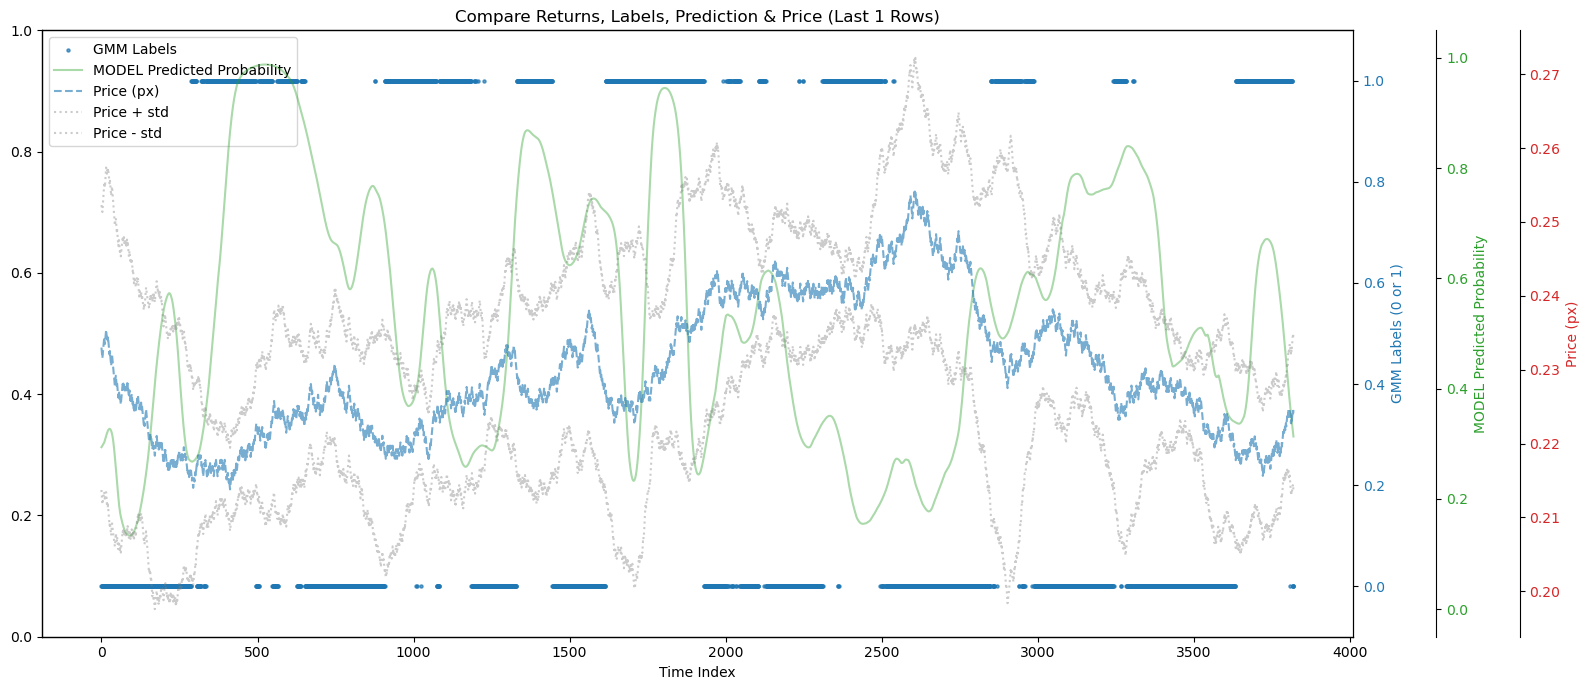

Test Week 5 Evaluation Completed
Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:03:47.419000 to 2025-05-18 23:59:03.907000
Val: 2025-05-19 00:00:36.761000 to 2025-05-25 23:57:02.353000
Test: 2025-05-26 00:03:02.054000 to 2025-06-01 23:50:02.845000
GMM 分量均值: [ 0.02484105 -0.01287874]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.024841) => 二元标签: 1
GMM 内部标签 1 (均值: -0.012879) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.0156547  0.01563025 0.01975974 0.01977591 0.01981699 0.01988907
 0.01981699 0.01980087 0.02401218 0.01985712]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.00430594 -0.00026689 -0.00026743 -0.00026689 -0.00026743  0.00442438
  0.00859907  0.00451437  0.00049068 -0.00356125]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.24765879 1.24765879 1.24765879 ... 0.83437713 0.83437713 0.83437713]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95961 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.1796  | val_0_balanced_accuracy: 0.5311  |  0:00:03s
epoch 10 | loss: 0.15287 | val_0_balanced_accuracy: 0.51468 |  0:00:06s
epoch 15 | loss: 0.13995 | val_0_balanced_accuracy: 0.54001 |  0:00:09s
epoch 20 | loss: 0.13477 | val_0_balanced_accuracy: 0.54857 |  0:00:12s
epoch 25 | loss: 0.12076 | val_0_balanced_accuracy: 0.50591 |  0:00:14s
epoch 30 | loss: 0.11705 | val_0_balanced_accuracy: 0.47977 |  0:00:17s
epoch 35 | loss: 0.11361 | val_0_balanced_accuracy: 0.47303 |  0:00:20s
epoch 40 | loss: 0.12374 | val_0_balanced_accuracy: 0.487   |  0:00:23s
epoch 45 | loss: 0.12085 | val_0_balanced_accuracy: 0.48268 |  0:00:25s

Early stopping occurred at epoch 47 with best_epoch = 17 and best_val_0_balanced_accuracy = 0.56624


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6096
✅ 自信预测准确率: 0.5931 (阈值 0.2-0.8)
📈 出手率: 64.05%

🧮 自信预测混淆矩阵:
[[1339  129]
 [ 867  113]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.61      0.91      0.73      1468
           1       0.47      0.12      0.18       980

    accuracy                           0.59      2448
   macro avg       0.54      0.51      0.46      2448
weighted avg       0.55      0.59      0.51      2448


=== tabnet 评估结果 ===
📊 全样本准确率: 0.7558
✅ 自信预测准确率: 0.7143 (阈值 0.2-0.8)
📈 出手率: 44.79%

🧮 自信预测混淆矩阵:
[[875  77]
 [273   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       952
           1       0.00      0.00      0.00       273

    accuracy                           0.71      1225
   macro avg       0.38      0.46      0.42      1225
weighted avg       0.59      0.71      0.65      1225



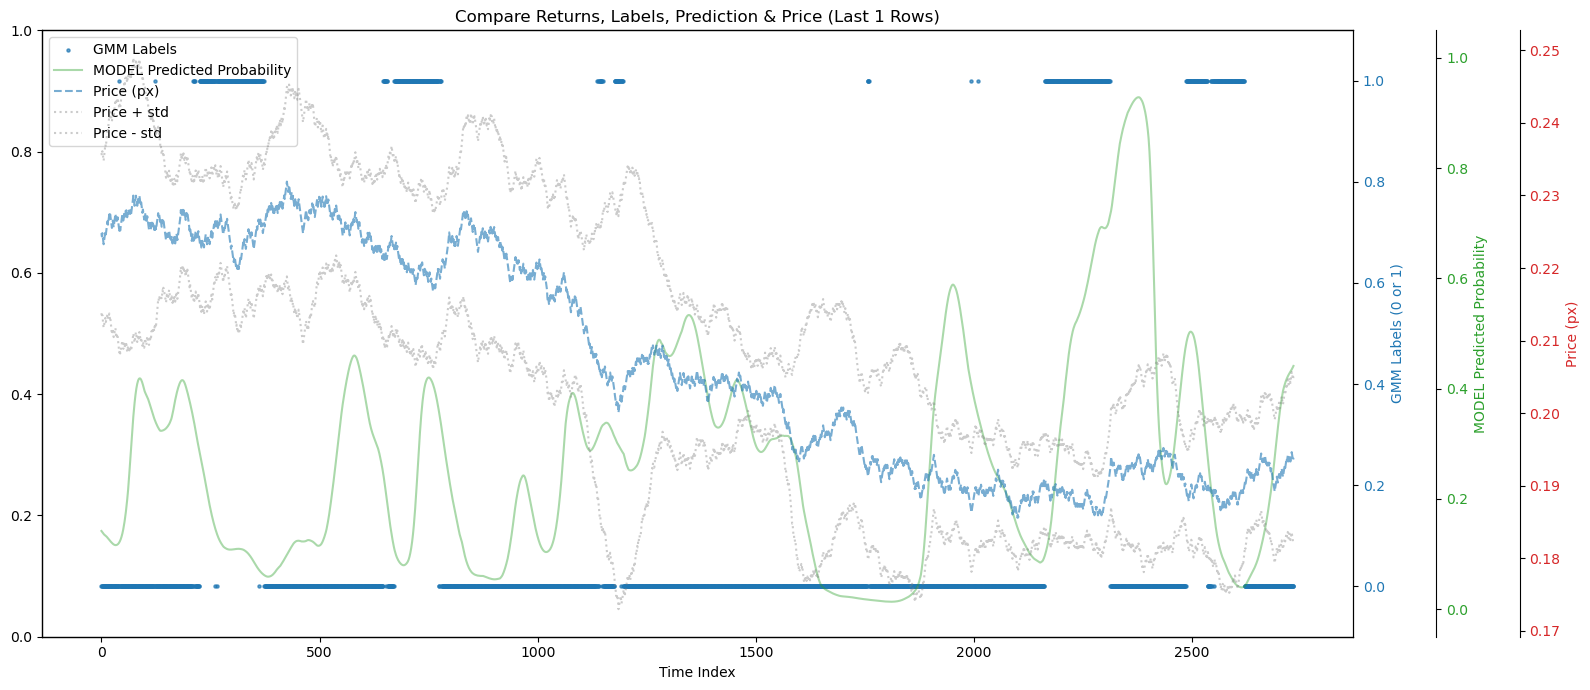

epoch 0  | loss: 0.32136 | val_0_balanced_accuracy: 0.46484 |  0:00:00s
epoch 5  | loss: 0.16248 | val_0_balanced_accuracy: 0.57362 |  0:00:03s
epoch 10 | loss: 0.14178 | val_0_balanced_accuracy: 0.55741 |  0:00:06s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_balanced_accuracy = 0.60561


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6376
✅ 自信预测准确率: 0.6240 (阈值 0.2-0.8)
📈 出手率: 45.16%

🧮 自信预测混淆矩阵:
[[883  89]
 [560 194]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.61      0.91      0.73       972
           1       0.69      0.26      0.37       754

    accuracy                           0.62      1726
   macro avg       0.65      0.58      0.55      1726
weighted avg       0.64      0.62      0.58      1726


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5305
✅ 自信预测准确率: 0.6330 (阈值 0.2-0.8)
📈 出手率: 42.74%

🧮 自信预测混淆矩阵:
[[678 285]
 [144  62]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       963
           1       0.18      0.30      0.22       206

    accuracy                           0.63      1169
   macro avg       0.50      0.50      0.49      1169
weighted avg       0.71      0.63      0.67      1169



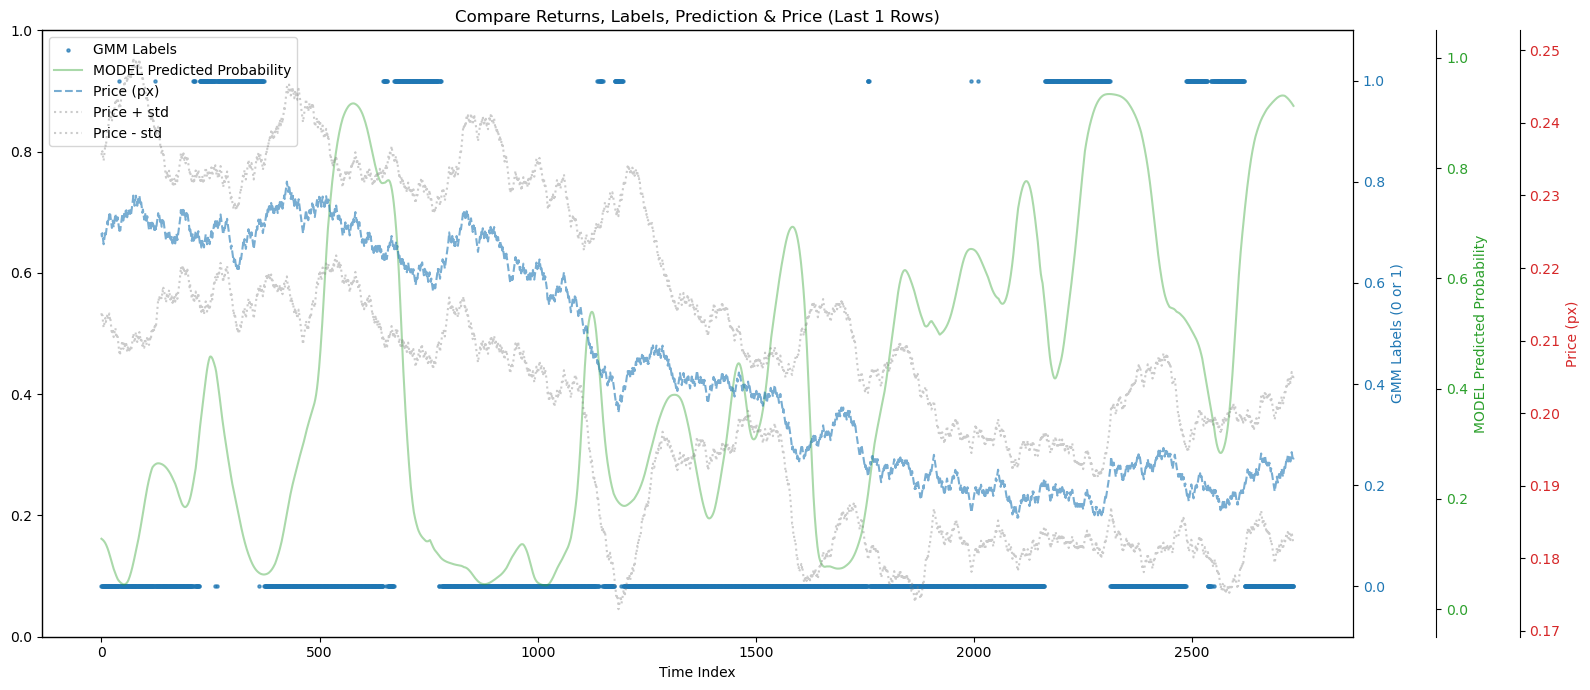

Test Week 6 Evaluation Completed
Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:01:40.038000 to 2025-05-25 23:57:02.353000
Val: 2025-05-26 00:03:02.054000 to 2025-06-01 23:50:02.845000
Test: 2025-06-02 00:06:42.547000 to 2025-06-08 23:29:55.817000
GMM 分量均值: [-0.01392593  0.02236945]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.013926) => 二元标签: 0
GMM 内部标签 1 (均值: 0.022369) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [-0.00509547 -0.00516462 -0.00919527 -0.01320942 -0.01738217 -0.01338477
 -0.01341577 -0.01338477 -0.01341577 -0.00941025]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.01351421 -0.01751757 -0.01748234 -0.01744725 -0.01743167 -0.0174668
 -0.01750207 -0.02144592 -0.01750207 -0.01753749]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[0.93077922 0.93077922 0.93077922 ... 0.93077922 0.93077922 0.93077922]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87722 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.18874 | val_0_balanced_accuracy: 0.33265 |  0:00:03s
epoch 10 | loss: 0.15971 | val_0_balanced_accuracy: 0.41096 |  0:00:07s
epoch 15 | loss: 0.14813 | val_0_balanced_accuracy: 0.44065 |  0:00:10s
epoch 20 | loss: 0.14481 | val_0_balanced_accuracy: 0.4379  |  0:00:13s
epoch 25 | loss: 0.14321 | val_0_balanced_accuracy: 0.36381 |  0:00:16s
epoch 30 | loss: 0.14173 | val_0_balanced_accuracy: 0.40786 |  0:00:19s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7634
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.6647
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


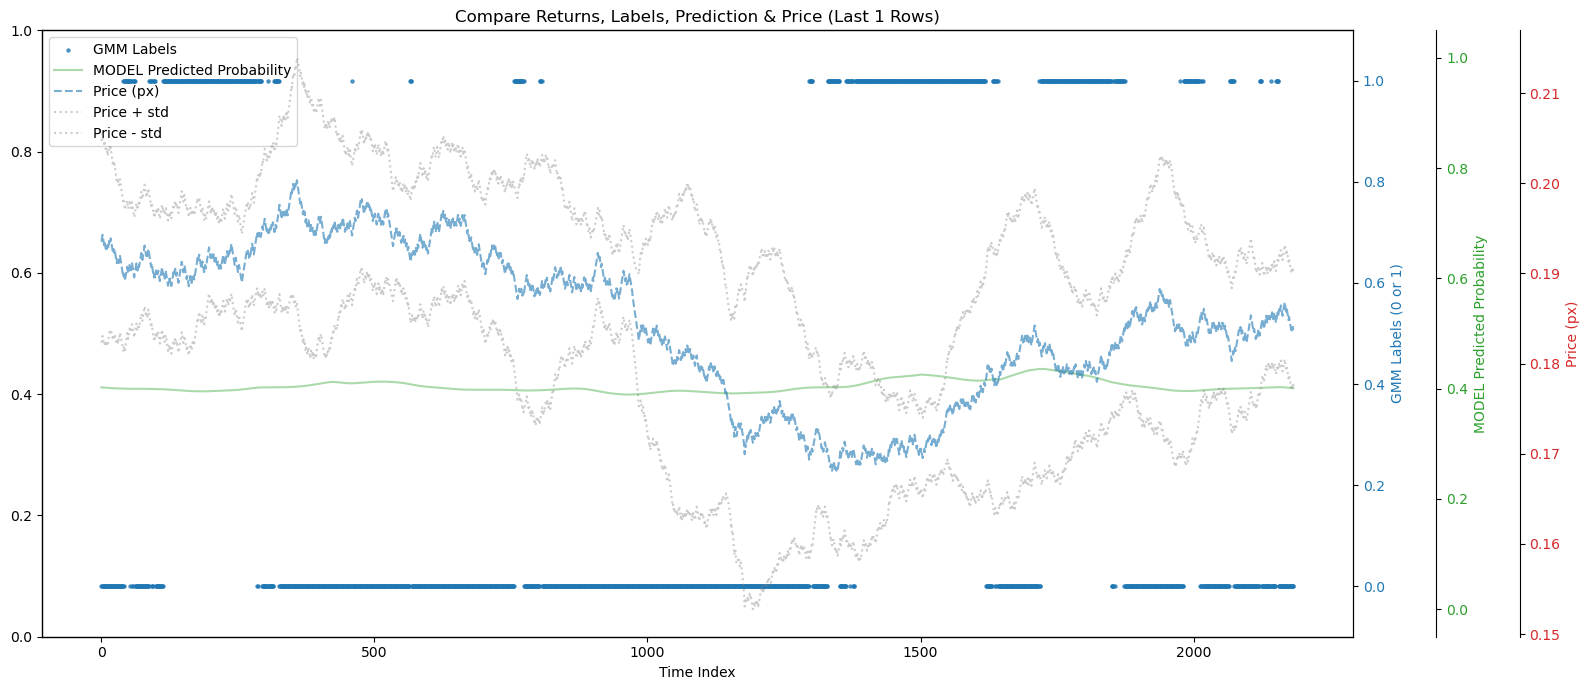

epoch 0  | loss: 0.25722 | val_0_balanced_accuracy: 0.50021 |  0:00:00s
epoch 5  | loss: 0.15264 | val_0_balanced_accuracy: 0.49651 |  0:00:03s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.54398


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5057
✅ 自信预测准确率: 0.4682 (阈值 0.2-0.8)
📈 出手率: 60.44%

🧮 自信预测混淆矩阵:
[[542 754]
 [125 232]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.81      0.42      0.55      1296
           1       0.24      0.65      0.35       357

    accuracy                           0.47      1653
   macro avg       0.52      0.53      0.45      1653
weighted avg       0.69      0.47      0.51      1653


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.4067
✅ 自信预测准确率: 0.3031 (阈值 0.2-0.8)
📈 出手率: 52.97%

🧮 自信预测混淆矩阵:
[[206 466]
 [341 145]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.38      0.31      0.34       672
           1       0.24      0.30      0.26       486

    accuracy                           0.30      1158
   macro avg       0.31      0.30      0.30      1158
weighted avg       0.32      0.30      0.31      1158



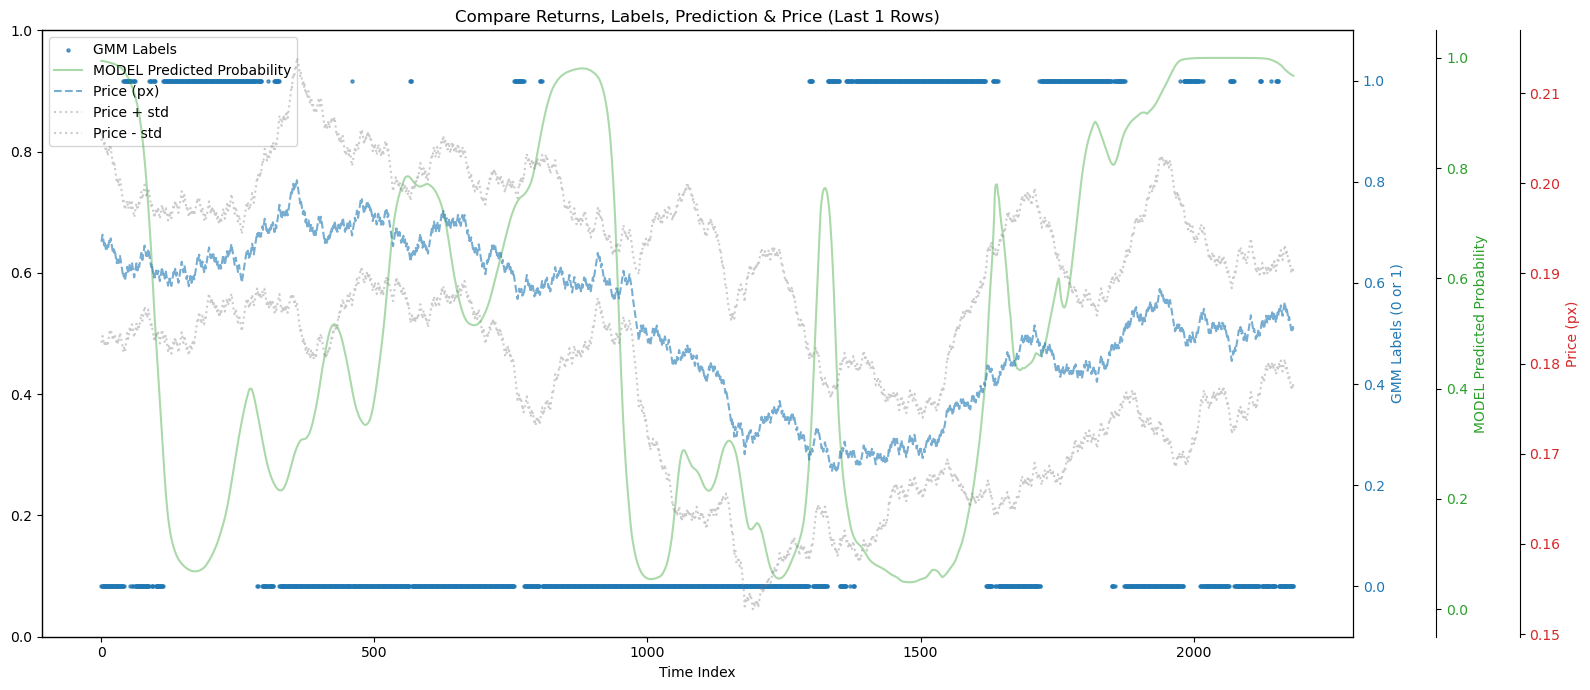

Test Week 7 Evaluation Completed
Fold 5: Train 5~7, Val 8, Test 9
Train: 2025-05-12 00:00:16.471000 to 2025-06-01 23:50:02.845000
Val: 2025-06-02 00:06:42.547000 to 2025-06-08 23:29:55.817000
Test: 2025-06-09 00:02:47.768000 to 2025-06-15 23:36:11.063000
GMM 分量均值: [-0.01745702  0.0161283 ]
上涨标签: 1, 下跌标签: 0

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: -0.017457) => 二元标签: 0
GMM 内部标签 1 (均值: 0.016128) => 二元标签: 1

--- 示例标签 ---
训练集原始收益: [0.01885324 0.01890131 0.01472868 0.01061589 0.01472868 0.01461109
 0.01464129 0.01052903 0.01055069 0.0104001 ]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [-0.00851133 -0.00852844 -0.00451774 -0.00450866 -0.00048988 -0.00048889
  0.00364685 -0.00038025  0.00364685  0.00365421]
测试集GMM标签: [0 0 0 0 0 0 1 0 1 1]
测试集二元标签: [0 0 0 0 0 0 1 0 1 1]
[1.15332842 1.15332842 1.15332842 ... 0.88265594 0.88265594 0.88265594]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92003 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.19908 | val_0_balanced_accuracy: 0.65312 |  0:00:03s
epoch 10 | loss: 0.17131 | val_0_balanced_accuracy: 0.64374 |  0:00:06s
epoch 15 | loss: 0.1506  | val_0_balanced_accuracy: 0.52059 |  0:00:09s
epoch 20 | loss: 0.14275 | val_0_balanced_accuracy: 0.57414 |  0:00:12s
epoch 25 | loss: 0.14103 | val_0_balanced_accuracy: 0.5412  |  0:00:14s
epoch 30 | loss: 0.1456  | val_0_balanced_accuracy: 0.50831 |  0:00:17s

Early stopping occurred at epoch 33 with best_epoch = 3 and best_val_0_balanced_accuracy = 0.68967


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.7338
✅ 自信预测准确率: 0.4159 (阈值 0.2-0.8)
📈 出手率: 9.79%

🧮 自信预测混淆矩阵:
[[ 89   0]
 [125   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.42      1.00      0.59        89
           1       0.00      0.00      0.00       125

    accuracy                           0.42       214
   macro avg       0.21      0.50      0.29       214
weighted avg       0.17      0.42      0.24       214


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5063
✅ 自信预测准确率: 0.2397 (阈值 0.2-0.8)
📈 出手率: 18.45%

🧮 自信预测混淆矩阵:
[[116   0]
 [368   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.24      1.00      0.39       116
           1       0.00      0.00      0.00       368

    accuracy                           0.24       484
   macro avg       0.12      0.50      0.19       484
weighted avg       0.06      0.24      0.09       484



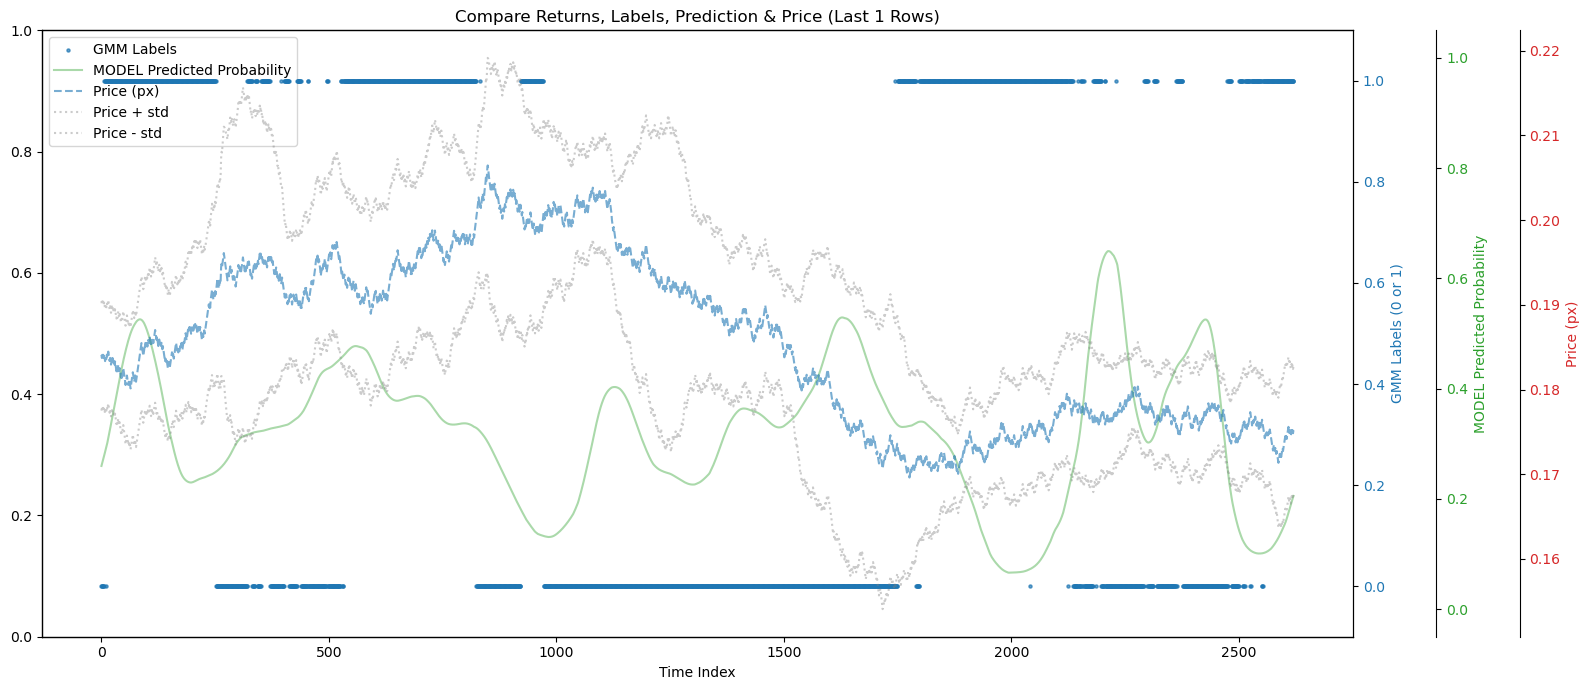

epoch 0  | loss: 0.2767  | val_0_balanced_accuracy: 0.51703 |  0:00:00s
epoch 5  | loss: 0.16887 | val_0_balanced_accuracy: 0.54308 |  0:00:04s
epoch 10 | loss: 0.14736 | val_0_balanced_accuracy: 0.53214 |  0:00:07s

Early stopping occurred at epoch 10 with best_epoch = 5 and best_val_0_balanced_accuracy = 0.54308


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5887
✅ 自信预测准确率: 0.5769 (阈值 0.2-0.8)
📈 出手率: 44.01%

🧮 自信预测混淆矩阵:
[[408  91]
 [316 147]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.56      0.82      0.67       499
           1       0.62      0.32      0.42       463

    accuracy                           0.58       962
   macro avg       0.59      0.57      0.54       962
weighted avg       0.59      0.58      0.55       962


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5433
✅ 自信预测准确率: 0.6443 (阈值 0.2-0.8)
📈 出手率: 56.81%

🧮 自信预测混淆矩阵:
[[787 164]
 [366 173]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       951
           1       0.51      0.32      0.39       539

    accuracy                           0.64      1490
   macro avg       0.60      0.57      0.57      1490
weighted avg       0.62      0.64      0.62      1490



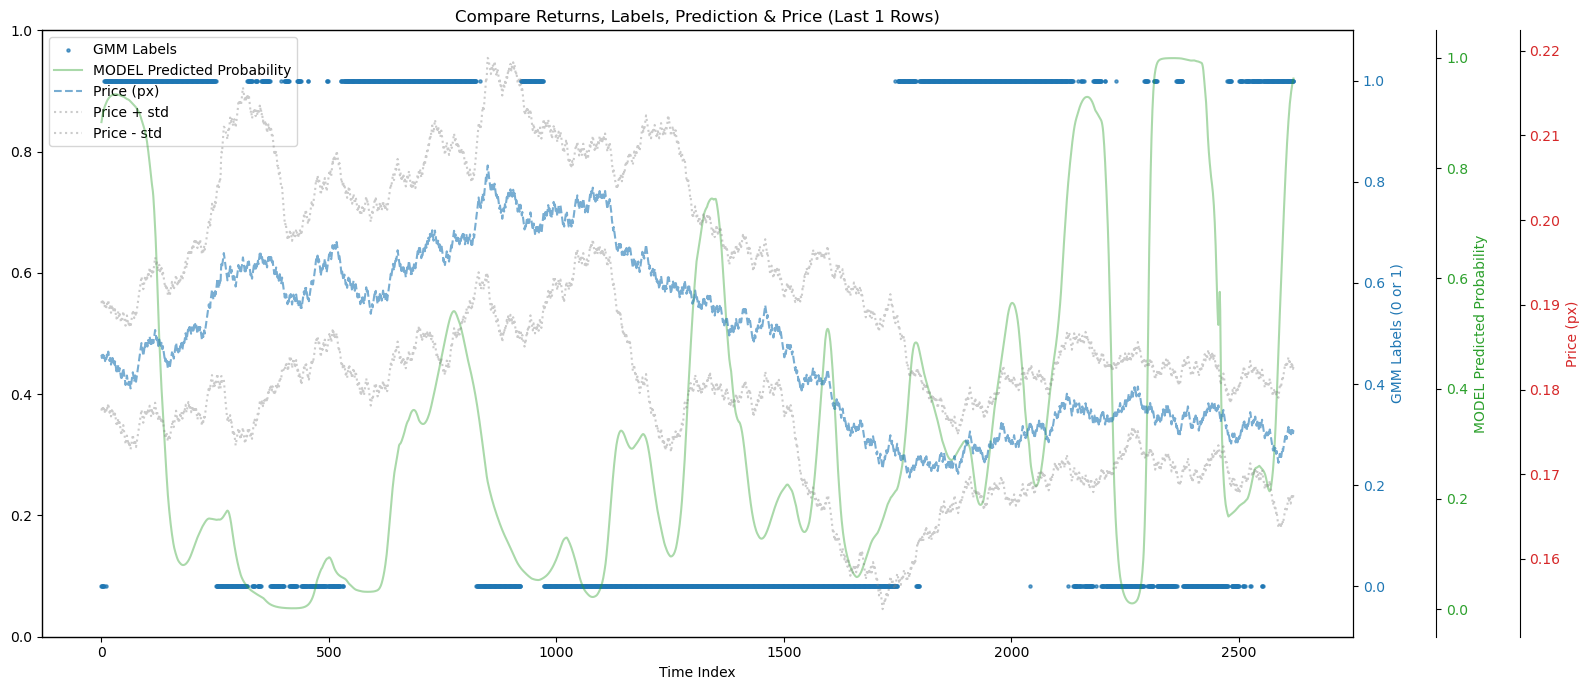

Test Week 8 Evaluation Completed
Fold 6: Train 6~8, Val 9, Test 10
Train: 2025-05-19 00:00:36.761000 to 2025-06-08 23:29:55.817000
Val: 2025-06-09 00:02:47.768000 to 2025-06-15 23:36:11.063000
Test: 2025-06-16 00:12:01.964000 to 2025-06-22 23:55:05.764000
GMM 分量均值: [ 0.01437878 -0.01945688]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.014379) => 二元标签: 1
GMM 内部标签 1 (均值: -0.019457) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.04938748 -0.04940126 -0.0494151  -0.04930609 -0.04543295 -0.04930609
 -0.04929032 -0.04931754 -0.05315913 -0.05702561]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [0.02061915 0.02478251 0.02061915 0.02057684 0.02056203 0.02478393
 0.02067862 0.02063619 0.02067862 0.02484259]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.94580268 0.94580268 0.94580268 ... 0.94580268 0.94580268 0.94580268]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98935 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.22773 | val_0_balanced_accuracy: 0.64073 |  0:00:02s
epoch 10 | loss: 0.18678 | val_0_balanced_accuracy: 0.6269  |  0:00:04s
epoch 15 | loss: 0.16369 | val_0_balanced_accuracy: 0.66055 |  0:00:07s
epoch 20 | loss: 0.15441 | val_0_balanced_accuracy: 0.63548 |  0:00:09s
epoch 25 | loss: 0.13892 | val_0_balanced_accuracy: 0.66284 |  0:00:11s
epoch 30 | loss: 0.13537 | val_0_balanced_accuracy: 0.65553 |  0:00:13s
epoch 35 | loss: 0.13708 | val_0_balanced_accuracy: 0.69729 |  0:00:15s
epoch 40 | loss: 0.12922 | val_0_balanced_accuracy: 0.67587 |  0:00:17s
epoch 45 | loss: 0.12892 | val_0_balanced_accuracy: 0.65239 |  0:00:19s
epoch 50 | loss: 0.1233  | val_0_balanced_accuracy: 0.67941 |  0:00:21s
epoch 55 | loss: 0.12221 | val_0_balanced_accuracy: 0.69649 |  0:00:23s
epoch 60 | loss: 0.12179 | val_0_balanced_accuracy: 0.6975  |  0:00:25s
epoch 65 | loss: 0.12424 | val_0_balanced_accuracy: 0.69437 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7141
✅ 自信预测准确率: 0.7055 (阈值 0.2-0.8)
📈 出手率: 65.50%

🧮 自信预测混淆矩阵:
[[745  90]
 [416 467]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.64      0.89      0.75       835
           1       0.84      0.53      0.65       883

    accuracy                           0.71      1718
   macro avg       0.74      0.71      0.70      1718
weighted avg       0.74      0.71      0.70      1718


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5548
✅ 自信预测准确率: 0.5616 (阈值 0.2-0.8)
📈 出手率: 66.68%

🧮 自信预测混淆矩阵:
[[845 131]
 [634 135]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.57      0.87      0.69       976
           1       0.51      0.18      0.26       769

    accuracy                           0.56      1745
   macro avg       0.54      0.52      0.47      1745
weighted avg       0.54      0.56      0.50      1745



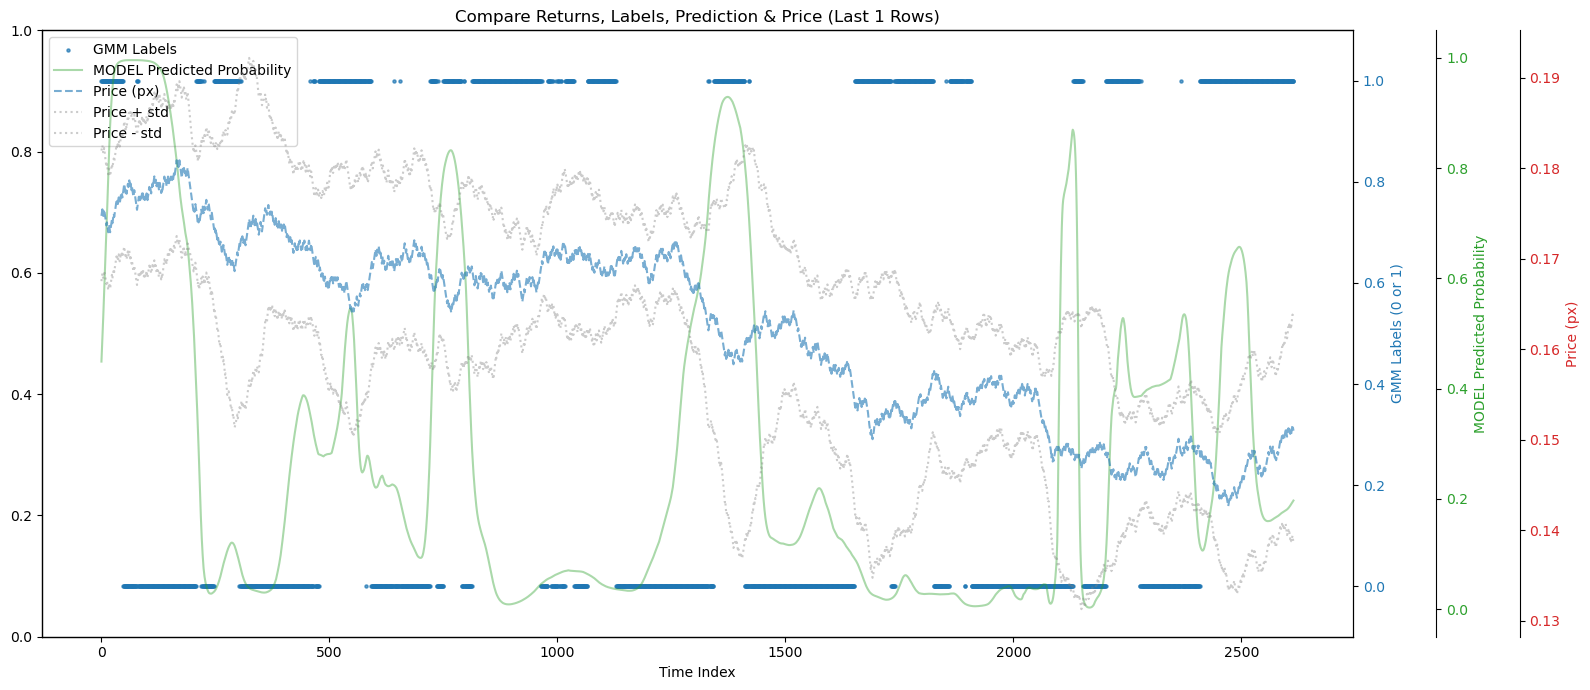

epoch 0  | loss: 0.27067 | val_0_balanced_accuracy: 0.60974 |  0:00:00s
epoch 5  | loss: 0.16426 | val_0_balanced_accuracy: 0.59359 |  0:00:02s

Early stopping occurred at epoch 5 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.60974


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6005
✅ 自信预测准确率: 0.5710 (阈值 0.2-0.8)
📈 出手率: 52.88%

🧮 自信预测混淆矩阵:
[[486  92]
 [503 306]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.49      0.84      0.62       578
           1       0.77      0.38      0.51       809

    accuracy                           0.57      1387
   macro avg       0.63      0.61      0.56      1387
weighted avg       0.65      0.57      0.55      1387


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5132
✅ 自信预测准确率: 0.4511 (阈值 0.2-0.8)
📈 出手率: 44.98%

🧮 自信预测混淆矩阵:
[[304 479]
 [167 227]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.65      0.39      0.48       783
           1       0.32      0.58      0.41       394

    accuracy                           0.45      1177
   macro avg       0.48      0.48      0.45      1177
weighted avg       0.54      0.45      0.46      1177



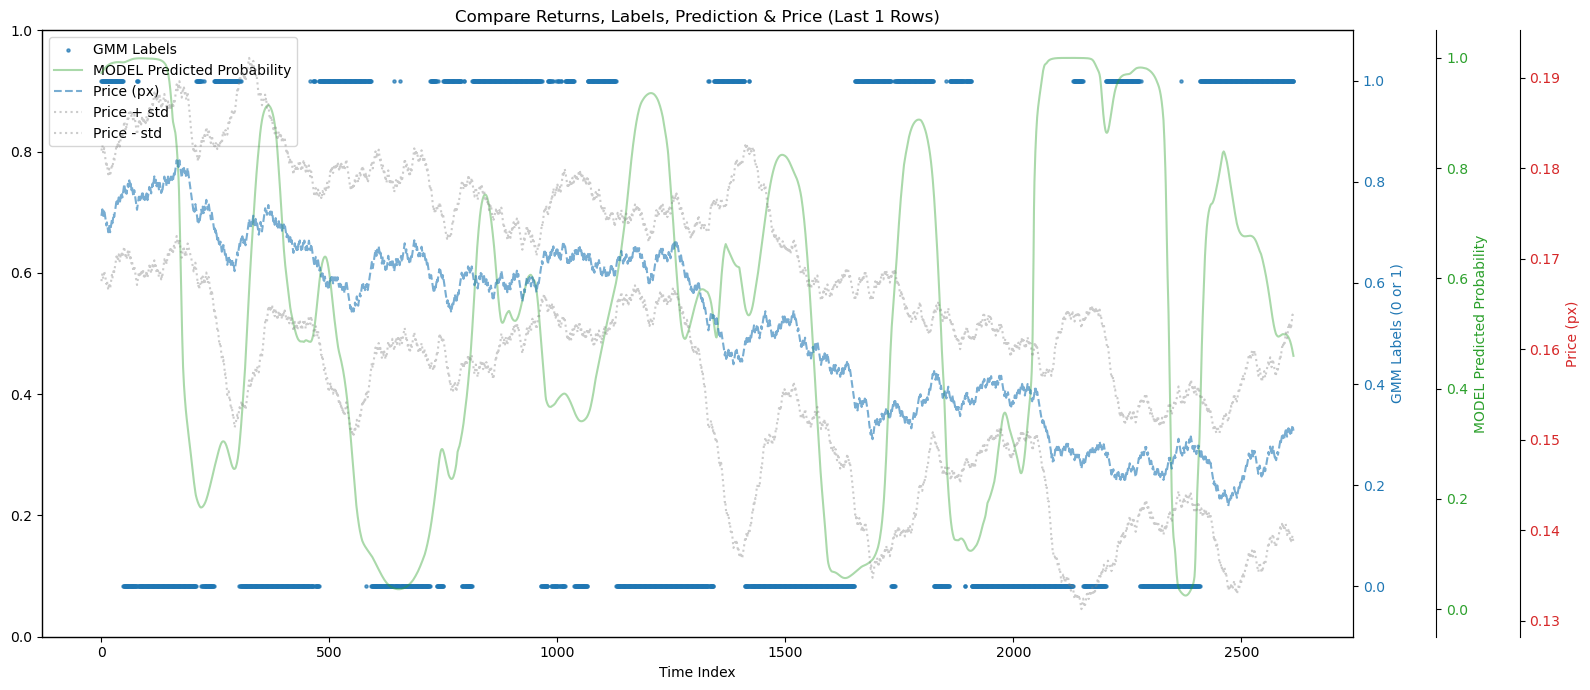

Test Week 9 Evaluation Completed
Fold 7: Train 7~9, Val 10, Test 11
Train: 2025-05-26 00:03:02.054000 to 2025-06-15 23:36:11.063000
Val: 2025-06-16 00:12:01.964000 to 2025-06-22 23:55:05.764000
Test: 2025-06-23 00:08:00.267000 to 2025-06-29 23:56:22.465000
GMM 分量均值: [ 0.0095822  -0.01977906]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.009582) => 二元标签: 1
GMM 内部标签 1 (均值: -0.019779) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.00430594 -0.00026689 -0.00026743 -0.00026689 -0.00026743  0.00442438
  0.00859907  0.00451437  0.00049068 -0.00356125]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 0]
训练集二元标签: [1 1 1 1 1 1 1 1 1 1]

测试集原始收益: [0.01782178 0.01792565 0.02234304 0.02236337 0.0223176  0.02286505
 0.02261521 0.02259552 0.02700026 0.02279465]
测试集GMM标签: [0 0 0 0 0 0 0 0 0 0]
测试集二元标签: [1 1 1 1 1 1 1 1 1 1]
[0.96175421 0.96175421 0.96175421 ... 0.96175421 0.96175421 0.96175421]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94667 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.29768 | val_0_balanced_accuracy: 0.5     |  0:00:02s
epoch 10 | loss: 0.20617 | val_0_balanced_accuracy: 0.5     |  0:00:04s
epoch 15 | loss: 0.18206 | val_0_balanced_accuracy: 0.46224 |  0:00:05s
epoch 20 | loss: 0.17573 | val_0_balanced_accuracy: 0.43591 |  0:00:07s
epoch 25 | loss: 0.15592 | val_0_balanced_accuracy: 0.45504 |  0:00:09s
epoch 30 | loss: 0.17057 | val_0_balanced_accuracy: 0.43557 |  0:00:11s

Early stopping occurred at epoch 30 with best_epoch = 0 and best_val_0_balanced_accuracy = 0.5


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.5006
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!

=== tabnet 评估结果 ===
📊 全样本准确率: 0.2700
✅ 自信预测准确率: nan (阈值 0.2-0.8)
📈 出手率: 0.00%
⚠️ 无自信预测样本!


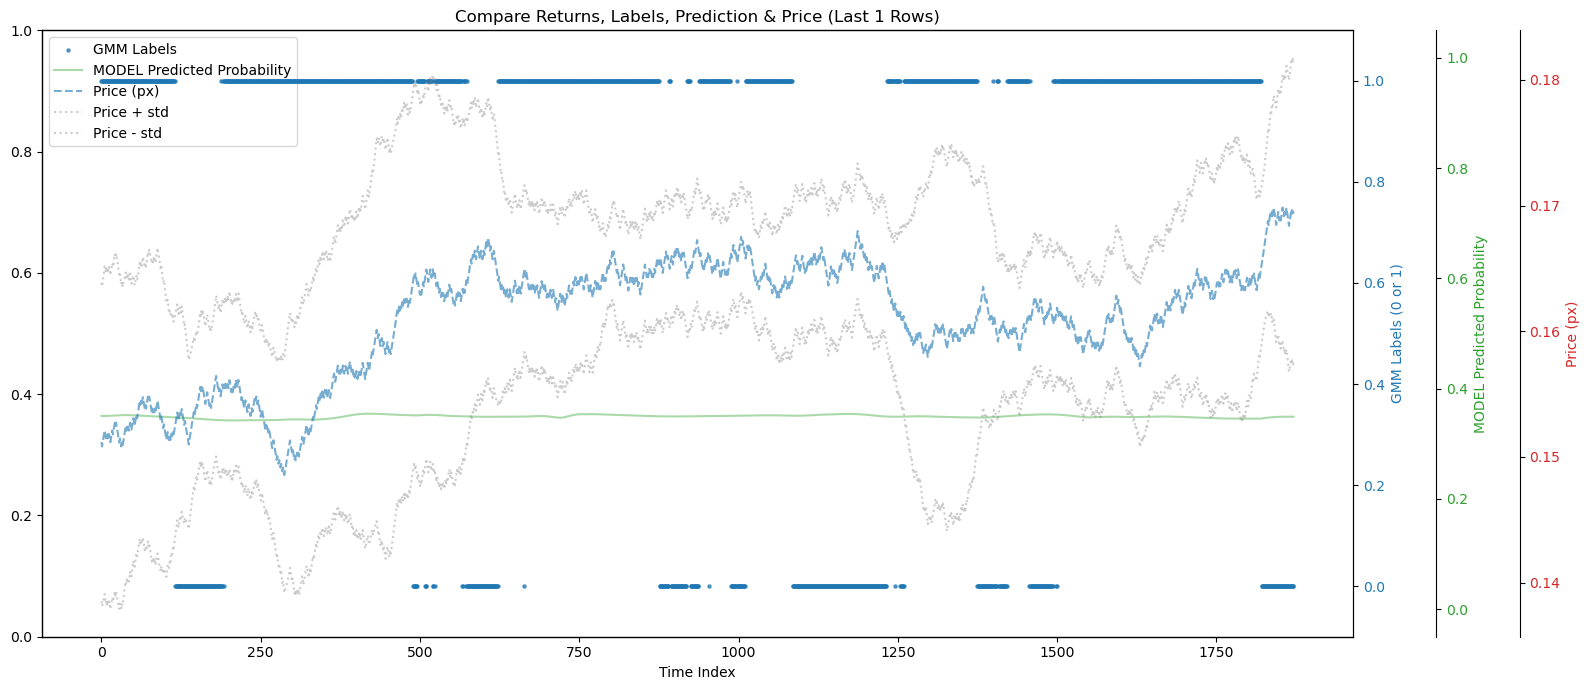

epoch 0  | loss: 0.39898 | val_0_balanced_accuracy: 0.46892 |  0:00:00s
epoch 5  | loss: 0.18294 | val_0_balanced_accuracy: 0.5335  |  0:00:02s

Early stopping occurred at epoch 6 with best_epoch = 1 and best_val_0_balanced_accuracy = 0.54509


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5449
✅ 自信预测准确率: 0.4708 (阈值 0.2-0.8)
📈 出手率: 39.28%

🧮 自信预测混淆矩阵:
[[127 433]
 [111 357]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.53      0.23      0.32       560
           1       0.45      0.76      0.57       468

    accuracy                           0.47      1028
   macro avg       0.49      0.49      0.44      1028
weighted avg       0.50      0.47      0.43      1028


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.3735
✅ 自信预测准确率: 0.3284 (阈值 0.2-0.8)
📈 出手率: 35.75%

🧮 自信预测混淆矩阵:
[[210   0]
 [450  10]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.32      1.00      0.48       210
           1       1.00      0.02      0.04       460

    accuracy                           0.33       670
   macro avg       0.66      0.51      0.26       670
weighted avg       0.79      0.33      0.18       670



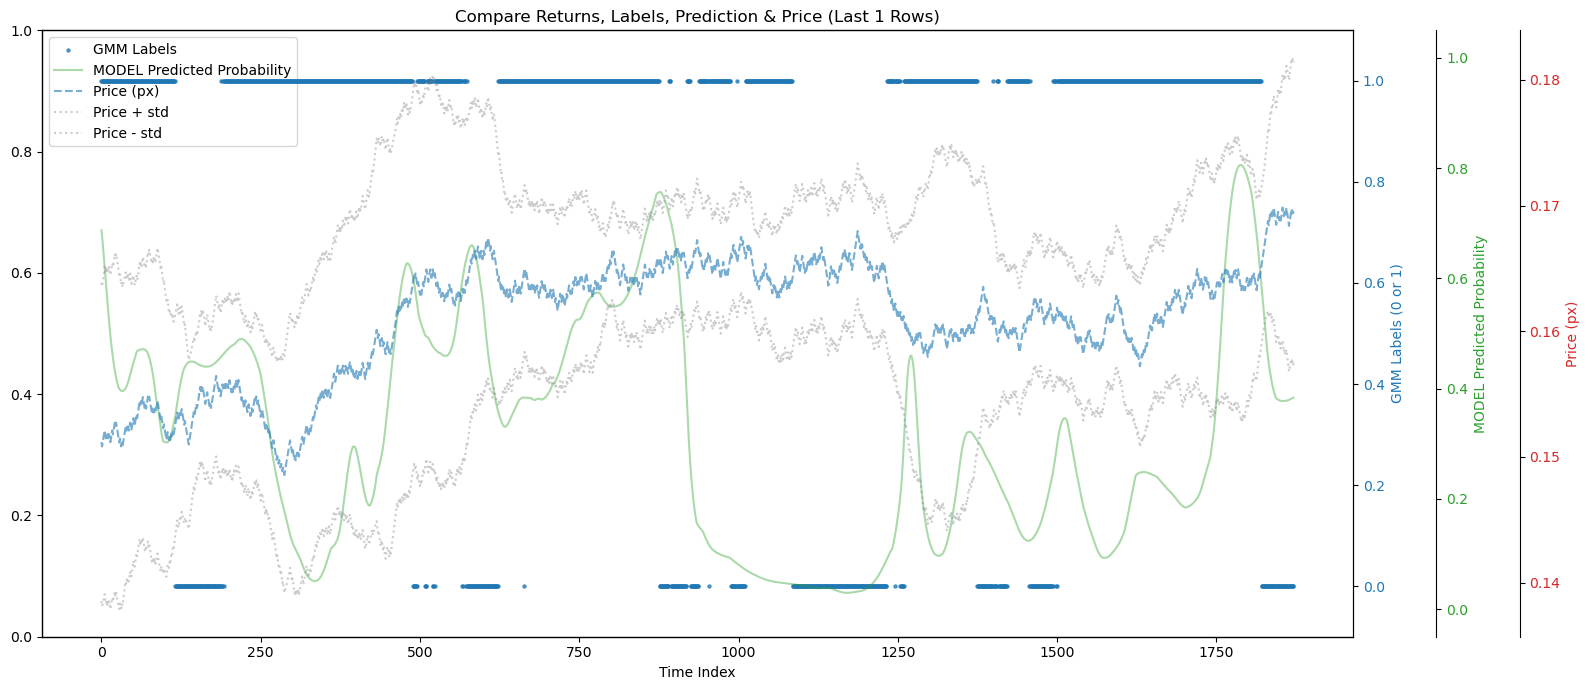

Test Week 10 Evaluation Completed
Fold 8: Train 8~10, Val 11, Test 12
Train: 2025-06-02 00:06:42.547000 to 2025-06-22 23:55:05.764000
Val: 2025-06-23 00:08:00.267000 to 2025-06-29 23:56:22.465000
Test: 2025-06-30 00:03:26.973000 to 2025-07-03 04:15:02.398000
GMM 分量均值: [ 0.00993108 -0.02497622]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.009931) => 二元标签: 1
GMM 内部标签 1 (均值: -0.024976) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-0.01351421 -0.01751757 -0.01748234 -0.01744725 -0.01743167 -0.0174668
 -0.01750207 -0.02144592 -0.01750207 -0.01753749]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.02627703 -0.02231537 -0.01827862 -0.01831545 -0.02230109 -0.02627074
 -0.03016556 -0.02621325 -0.03016733 -0.02627229]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]
[1.32088225 1.32088225 1.32088225 ... 0.80455038 0.80455038 0.80455038]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98358 | val_0_balanced_accuracy: 0.5     |  0:00:00s
epoch 5  | loss: 0.25509 | val_0_balanced_accuracy: 0.63035 |  0:00:02s
epoch 10 | loss: 0.17646 | val_0_balanced_accuracy: 0.62098 |  0:00:03s
epoch 15 | loss: 0.14823 | val_0_balanced_accuracy: 0.55964 |  0:00:05s
epoch 20 | loss: 0.14754 | val_0_balanced_accuracy: 0.52129 |  0:00:07s
epoch 25 | loss: 0.13912 | val_0_balanced_accuracy: 0.52687 |  0:00:09s
epoch 30 | loss: 0.134   | val_0_balanced_accuracy: 0.50221 |  0:00:10s
epoch 35 | loss: 0.12305 | val_0_balanced_accuracy: 0.52244 |  0:00:12s
epoch 40 | loss: 0.1163  | val_0_balanced_accuracy: 0.55406 |  0:00:14s

Early stopping occurred at epoch 41 with best_epoch = 11 and best_val_0_balanced_accuracy = 0.69314


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.6958
✅ 自信预测准确率: 0.9559 (阈值 0.2-0.8)
📈 出手率: 19.37%

🧮 自信预测混淆矩阵:
[[  0  16]
 [  0 347]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.96      1.00      0.98       347

    accuracy                           0.96       363
   macro avg       0.48      0.50      0.49       363
weighted avg       0.91      0.96      0.93       363


=== tabnet 评估结果 ===
📊 全样本准确率: 0.7019
✅ 自信预测准确率: 0.8879 (阈值 0.2-0.8)
📈 出手率: 59.44%

🧮 自信预测混淆矩阵:
[[  0  36]
 [  0 285]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.89      1.00      0.94       285

    accuracy                           0.89       321
   macro avg       0.44      0.50      0.47       321
weighted avg       0.79      0.89      0.84       321



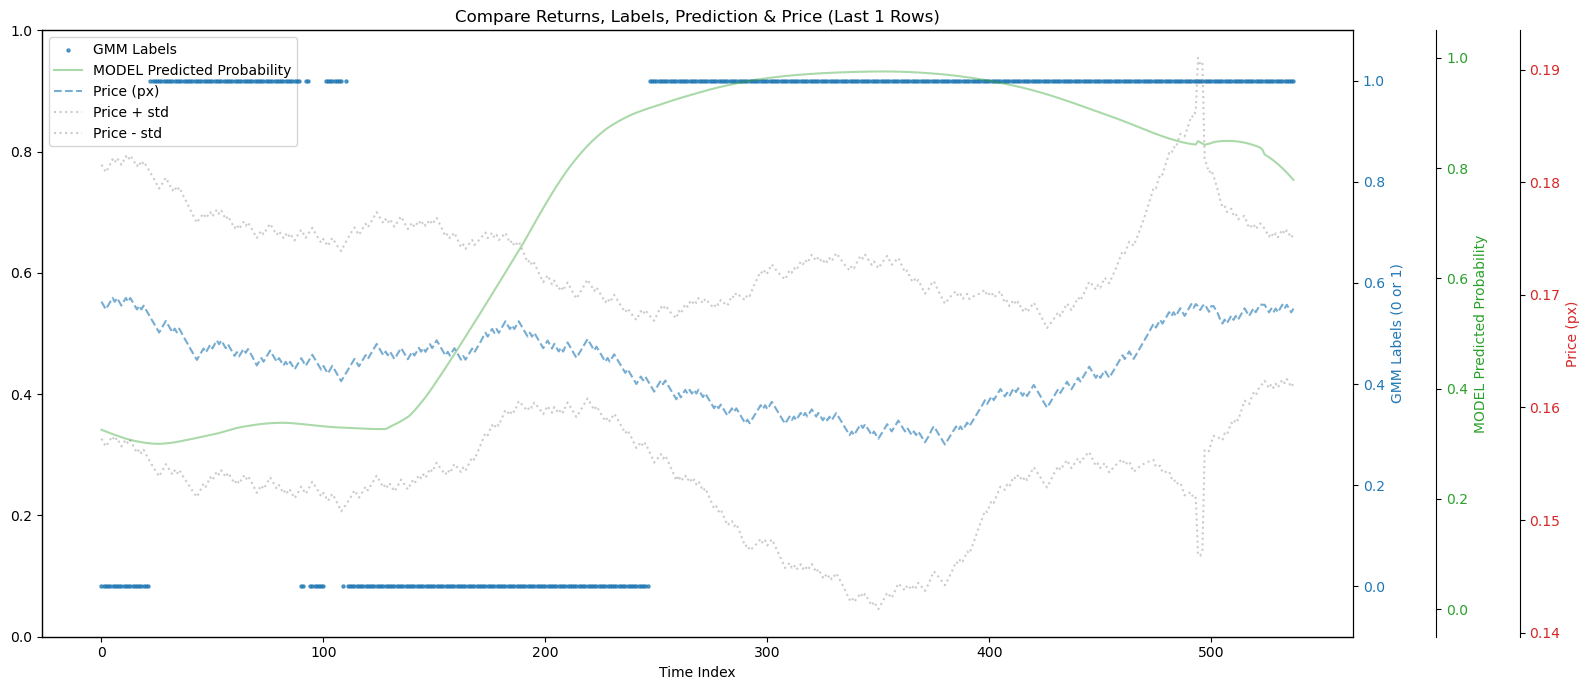

epoch 0  | loss: 0.34838 | val_0_balanced_accuracy: 0.5364  |  0:00:00s
epoch 5  | loss: 0.16861 | val_0_balanced_accuracy: 0.48468 |  0:00:02s

Early stopping occurred at epoch 7 with best_epoch = 2 and best_val_0_balanced_accuracy = 0.54347


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.2924
✅ 自信预测准确率: 0.2342 (阈值 0.2-0.8)
📈 出手率: 50.80%

🧮 自信预测混淆矩阵:
[[218   0]
 [729   5]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.23      1.00      0.37       218
           1       1.00      0.01      0.01       734

    accuracy                           0.23       952
   macro avg       0.62      0.50      0.19       952
weighted avg       0.82      0.23      0.10       952


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7333
✅ 自信预测准确率: 0.8780 (阈值 0.2-0.8)
📈 出手率: 69.81%

🧮 自信预测混淆矩阵:
[[ 61  28]
 [ 18 270]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        89
           1       0.91      0.94      0.92       288

    accuracy                           0.88       377
   macro avg       0.84      0.81      0.82       377
weighted avg       0.87      0.88      0.88       377



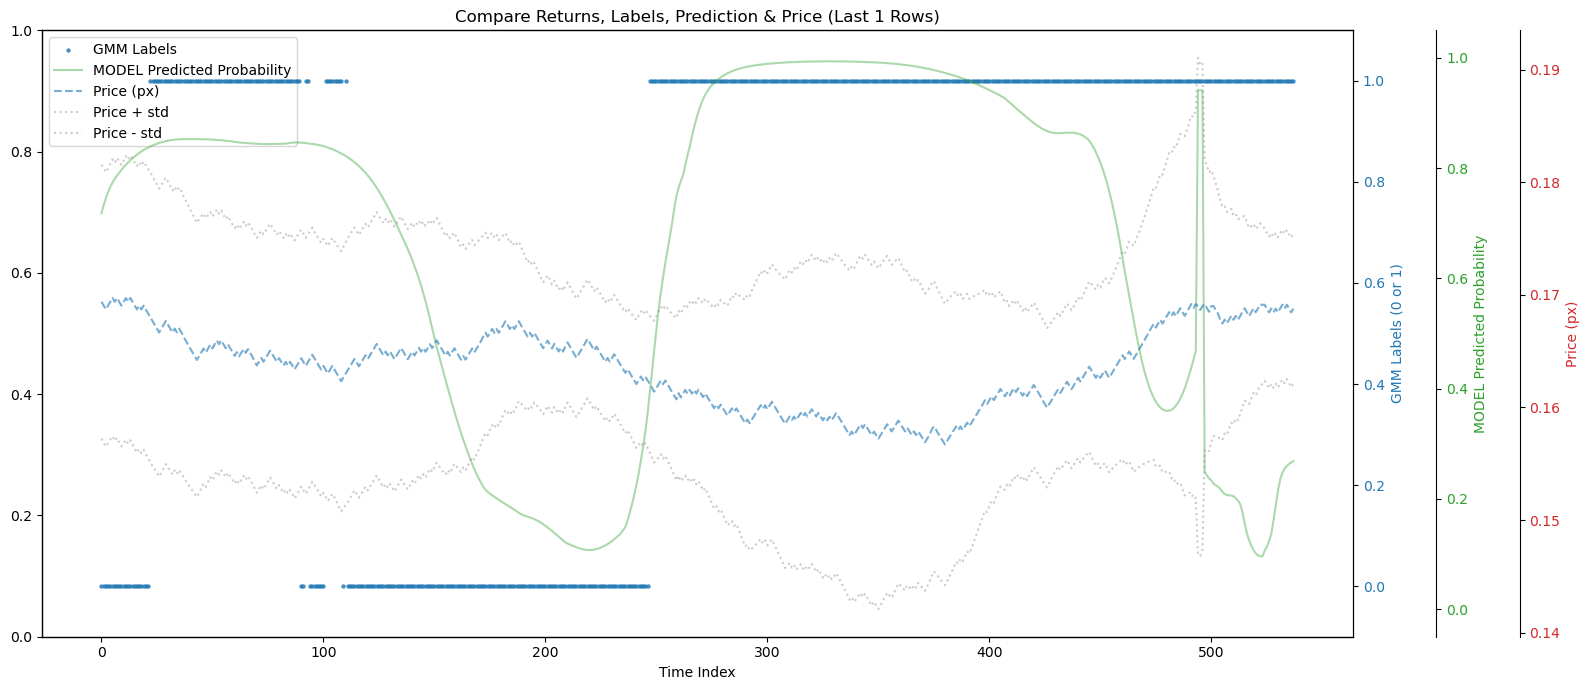

Test Week 11 Evaluation Completed

--- Final Predictions DataFrame for Backtesting ---
       timestamp   symbol  true_label  predicted_prob       px  rolling_std
0  1746403300038  BTCUSDT           0        0.364872  0.17074     0.001782
1  1746403383232  BTCUSDT           0        0.364946  0.17039     0.001795
2  1746403640622  BTCUSDT           0        0.365020  0.17074     0.001805
3  1746404534083  BTCUSDT           0        0.365093  0.17109     0.001811
4  1746404940940  BTCUSDT           0        0.365165  0.17144     0.001815
Total rows collected: 26909
整体训练时间范围：2025-04-07 14:37:36.494000 到 2025-07-03 04:15:02.398000


In [14]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{step}"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("zd_scaled") 
        and (col.startswith("z_")) 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# print(feature_cols)

# feature_cols = ["z_oi_di"]
results = []
all_tab_inc_test_predictions = []
all_tabnet_test_predictions = []
all_lgb_test_predictions = []

lgb_model = None
tab_inc = None
tab_inc_flag = 0

overall_start = None
overall_end = None


for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])

    fold_start = train_df['timestamp_dt'][0]
    fold_end = test_df['timestamp_dt'][-1]

    # 更新 overall_start 和 overall_end
    if overall_start is None or fold_start < overall_start:
        overall_start = fold_start
    if overall_end is None or fold_end > overall_end:
        overall_end = fold_end
        
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']
    std_train =train_df_processed['rolling_std']
    
    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']
    std_val =val_df_processed['rolling_std']
    timestamps_val = val_df_processed['timestamp'] # 收集时间戳

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    std_test =test_df_processed['rolling_std']
    timestamps_test = test_df_processed['timestamp'] # 收集时间戳

    y_train, y_val, y_test, gmm_model = gmm_label_binarize(y_train, y_val, y_test, verbose=True)


    # modellllllll
    up_thresh = 0.2
    lower_thresh = 0.8

    # sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

    # # # #LGBM
    # if lgb_model == None:
    #     lgb_model = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.005, max_depth=7, verbose=-1)
    #     early_stopping_callback = lgb.early_stopping(
    #         stopping_rounds=500,  # 耐心值：如果验证集性能在连续100轮内没有提升，就停止训练
    #         verbose=True,          # 打印早停信息，例如在第多少轮停止，最佳分数是多少
    #     )
    #     lgb_model.fit(
    #         X_train, y_train,
    #         sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #         eval_set=[(X_val, y_val)],
    #         eval_metric='acc',
    #         # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    #     )

    # else:
    #     lgb_model.fit(
    #         X_train, y_train,
    #         sample_weight=sample_weights,  # ✅ 添加 sample_weight
    #         eval_set=[(X_val, y_val)],
    #         eval_metric='acc',
    #         # callbacks=[early_stopping_callback], # 将早停回调传入 callbacks 参数
    #     )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # # plot_last_n_rows_with_px(y_val, y_val, lgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(lgb_model.predict_proba(X_test)[:, 1], y_test, lgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
    # lgb_test_pred_probs = lgb_model.predict_proba(X_test)[:, 1]

    # current_window_results = pd.DataFrame({
    #     'timestamp': timestamps_test,
    #     'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
    #     'true_label': y_test,
    #     'predicted_prob': lgb_test_pred_probs,
    #     'px': px_test, # 收集价格，回测时需要
    #     'rolling_std': std_test # 收集波动率，可能用于策略或分析
    #     # 添加任何你回测需要的其他数据
    # })
    # all_lgb_test_predictions.append(current_window_results)

    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val, xgb_model.predict_proba(X_val)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test, xgb_model.predict_proba(X_test)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    params = {
        # 模型结构参数
        "n_d": 16,                      # 决策输出维度
        "n_a": 16,                      # 注意力机制维度
        "n_steps": 3,                  # 决策步数
        "gamma": 1.3,                  # 控制特征复用的程度（>1）
        "n_independent": 3,           # 每个 step 的独立 Feature Transformer 层数
        "n_shared": 2,                # 每个 step 的共享 Feature Transformer 层数
    
        # 分类特征嵌入（如果你用的都是 float 特征，可以全留空）
        "cat_idxs": [],               # 类别特征的列索引
        "cat_dims": [],               # 每个类别特征的类别数
        "cat_emb_dim": 1,             # 类别特征的嵌入维度（或 list）
    
        # 正则化与数值稳定性
        "lambda_sparse": 1e-4,        # 稀疏正则
        "epsilon": 1e-15,             # sparsemax 稳定项
        "momentum": 0.03,             # BatchNorm 的动量
        "clip_value": 3.0,            # 梯度裁剪
        
        # 注意力 mask 类型
        "mask_type": "entmax",     # sparsemax 或 entmax
    
        # 优化器设置（函数和参数）
        # "optimizer_fn": torch.optim.Adam,    
        "optimizer_params": {"lr": 1e-2},
    
        # 学习率调度器（可选）
        "scheduler_fn": None,         # torch.optim.lr_scheduler.StepLR 等
        "scheduler_params": {},       # 比如 {"step_size": 20, "gamma": 0.95}
    
        # 预训练解码器结构（一般用不到）
        "n_shared_decoder": 1,
        "n_indep_decoder": 1,
    
        # 训练环境和调试
        "seed": 7,
        "verbose": 5,
        "device_name": "cuda",        # auto / cpu / cuda
    }

    init_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 300,
        "patience": 30,
        "batch_size": 1024,
        "virtual_batch_size": 256,
    }

    inc_fit_params = {
        "eval_metric": ['balanced_accuracy'],
        "max_epochs": 50,
        "patience": 5,
        "batch_size": 1024,
        "virtual_batch_size": 256,
        "warm_start": True,
    }

    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train.astype(int)
    y_val_enc = y_val.astype(int)
    
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_enc)
    print(sample_weights)
    # TabNet 训练
    tabnet = TabNetClassifier(**params)
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        weights=sample_weights,
        **init_fit_params,
    )

    # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
    
    tabnet_eval = evaluate_with_confidence(
        y_true=y_val,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    # plot_last_n_rows_with_px(y_val, y_val, tabnet.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )

    plot_last_n_rows_with_px(y_test, y_test, tabnet.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tabnet.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tabnet_test_predictions.append(current_window_results)

    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(**params)
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **init_fit_params,
        )

        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        # proba_smooth = softmax_with_temperature(proba_raw, temperature=1.5)
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)
        

    else:
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            weights=sample_weights,
            **inc_fit_params,
        )

        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        # plot_last_n_rows_with_px(y_val, y_val, tab_inc.predict_proba(X_val.values)[:, 1], px_val, std_array=std_val, n=1, m=-1, alpha=alpha)
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test, tab_inc.predict_proba(X_test.values)[:, 1], px_test, std_array=std_test, n=1, m=-1, alpha=alpha)

    current_window_results = pd.DataFrame({
        'timestamp': timestamps_test,
        'symbol': "BTCUSDT", # 如果有多个股票，收集 symbol 是必要的
        'true_label': y_test,
        'predicted_prob': tab_inc.predict_proba(X_test.values)[:, 1],
        'px': px_test, # 收集价格，回测时需要
        'rolling_std': std_test # 收集波动率，可能用于策略或分析
        # 添加任何你回测需要的其他数据
    })
    all_tab_inc_test_predictions.append(current_window_results)

    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        # 'LGBM': lgb_eval,
        # 'CatBoost': cat_model,
        # 'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")
 
final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

print("\n--- Final Predictions DataFrame for Backtesting ---")
print(final_predictions_df.head())
print(f"Total rows collected: {len(final_predictions_df)}") 
print(f"整体训练时间范围：{overall_start} 到 {overall_end}")
overall_start = str(overall_start)
overall_end = str(overall_end)

In [15]:
print(tab_inc.classes_)  # 输出通常是 array([0, 1])


[0 1]


In [16]:
# import pickle

# pkl_path = "./saved_models/tabnet_inc/model_2025-06-22_19-51/auxiliary.pkl"

# with open(pkl_path, "rb") as f:
#     data = pickle.load(f)

# print(data)


In [17]:
print(len(X_test.columns))

1495


In [18]:
explain_matrix, masks = tab_inc.explain(X_test.values)


Top 20 Features by Importance:

z_px_pct_rol_sum_20_minus_z_sum_sz_px_pct_rol_sum_500_zd_scaled Importance: 0.332376
z_px_pct_rol_sum_20_minus_z_oi_px_diff_500_zd_scaled Importance: 0.315421
z_factor_long_term_oi_volatility_minus_z_factor_impact_momentum_zd_scaled Importance: 0.225621
z_sum_sz_rol_mean_500_minus_z_oi_di_zd_scaled Importance: 0.165684
z_oi_down_divergence_minus_z_factor_momentum_trend_confirm_zd_scaled Importance: 0.133094
z_px_pct_rol_sum_500_minus_z_factor_px_oi_long_term_force_zd_scaled Importance: 0.126707
z_factor_oi_px_divergence_with_sign_diff_1_zd_scaled Importance: 0.124399
z_px_pct_rol_sum_500_minus_z_factor_impact_momentum_zd_scaled Importance: 0.124020
z_oi_di_minus_z_factor_oi_momentum_long_term_punch_zd_scaled Importance: 0.119445
z_oi_di_minus_z_factor_order_sentiment_divergence_zd_scaled Importance: 0.100426
z_factor_oi_change_minus_z_factor_impact_sensitivity_zd_scaled Importance: 0.098236
z_factor_short_term_oi_trend_minus_z_sum_sz_px_pct_rol_sum_500_z

C:\Users\Grayman\AppData\Local\Temp\ipykernel_33144\2508309008.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


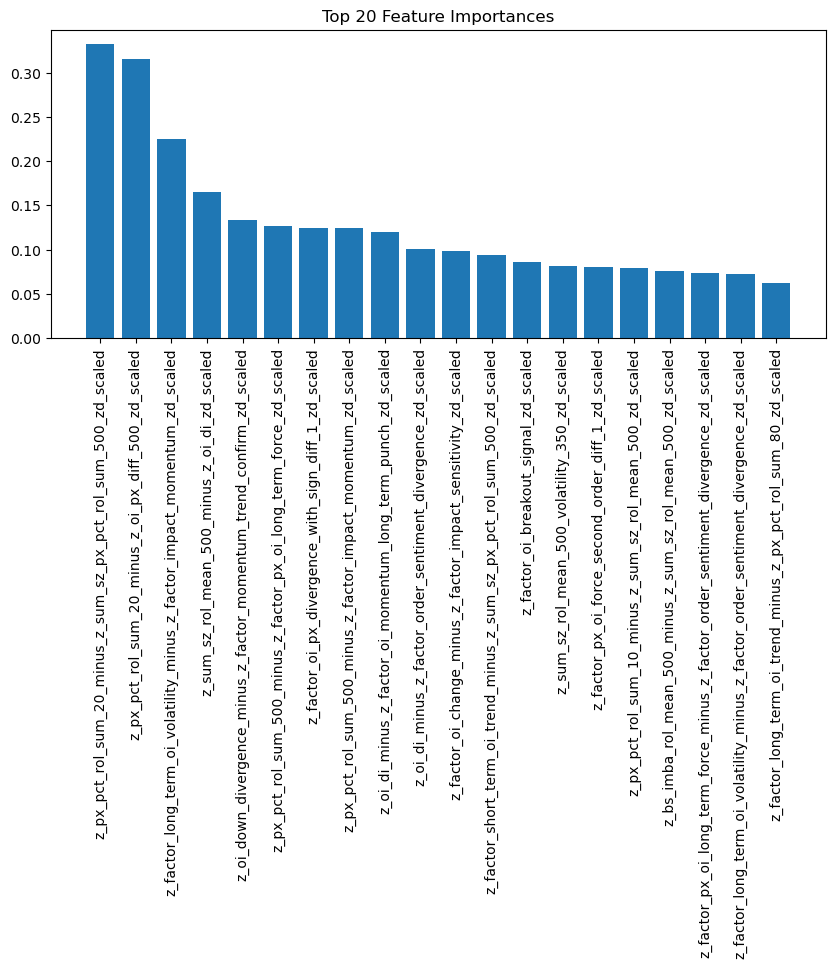

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 explain_matrix 是 TabNetClassifier 的解释矩阵 (n_samples, n_features)
mean_importance = np.mean(np.abs(explain_matrix), axis=0)
top_n = 20
top_indices = np.argsort(mean_importance)[::-1][:top_n]

# 特征名
top_feature_names = [X_train.columns[i] for i in top_indices]
top_importance_values = mean_importance[top_indices]

# 打印 Top N 特征名 + 权重
print(f"Top {top_n} Features by Importance:\n")
for name, score in zip(top_feature_names, top_importance_values):
    print(f"{name:<40} Importance: {score:.6f}")

# 画图
plt.figure(figsize=(10, 4))
plt.bar(range(top_n), top_importance_values)
plt.xticks(range(top_n), top_feature_names, rotation=90)
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

mask_sample = masks[0][0]  # 第0步，第0个样本的mask
nonzero_indices = np.nonzero(mask_sample)[0]  # 找非零位置索引

print("被关注的特征索引:", nonzero_indices)
print("对应的权重:", mask_sample[nonzero_indices])

# 假设你的特征名列表是 feature_names（长度460）
for idx in nonzero_indices:
    print(f"特征: {X_train.columns[idx]}, 权重: {mask_sample[idx]:.4f}")


被关注的特征索引: [  44   52   83  204  361  391  562  687  728  764  805  811  829  868
  948 1107 1115 1123 1251 1283 1294 1304 1331 1357 1365 1436 1456 1485]
对应的权重: [1.59808306e-03 2.61260495e-02 3.59962025e-04 1.12138003e-01
 1.13150105e-03 4.23919559e-02 9.85598005e-03 7.58904442e-02
 1.26007793e-03 1.35862222e-02 6.99306428e-02 7.44996651e-05
 1.58137141e-03 4.29969421e-03 8.95414501e-02 3.71706928e-03
 6.48328513e-02 1.31628430e-02 3.92158702e-03 1.62331038e-03
 3.30514275e-02 1.22523233e-01 3.85845639e-03 4.55351605e-04
 1.36923583e-04 1.06056623e-01 1.69024631e-01 2.78694220e-02]
特征: z_factor_oi_momentum_punch_zd_scaled, 权重: 0.0016
特征: z_factor_oi_change_lag_50_zd_scaled, 权重: 0.0261
特征: z_factor_short_term_oi_trend_second_order_diff_1_zd_scaled, 权重: 0.0004
特征: z_bs_imba_rol_mean_500_lag_20_zd_scaled, 权重: 0.1121
特征: z_factor_px_oi_force_diff_1_zd_scaled, 权重: 0.0011
特征: z_factor_impact_momentum_volatility_350_zd_scaled, 权重: 0.0424
特征: z_factor_short_term_oi_volatility_minus_z_lob_ratio_

In [21]:
import numpy as np
import pandas as pd

def show_tabnet_attention_masks(masks, feature_names, sample_idx=0, top_k=10):
    """
    显示 TabNet 对某个样本在每一步中关注的特征及其权重。

    参数:
    - masks: tabnet.explain(X)[1] 返回的字典
    - feature_names: list[str]，对应 X_train.columns
    - sample_idx: 选哪个样本
    - top_k: 最多展示前多少个非零特征
    """
    for step, mask_array in masks.items():
        mask_sample = mask_array[sample_idx]  # shape = (num_features,)
        nonzero_indices = np.nonzero(mask_sample)[0]
        weights = mask_sample[nonzero_indices]
        
        # 按照权重从高到低排序
        sorted_idx = np.argsort(-weights)
        top_indices = nonzero_indices[sorted_idx[:top_k]]
        
        print(f"\n🧭 Step {step}（共{len(nonzero_indices)}个非零特征）:")
        for i in top_indices:
            print(f"  特征: {feature_names[i]:<30} 权重: {mask_sample[i]:.4f}")


In [22]:
# 假设你已经有
# masks = tabnet.explain(X_test)[1]
# feature_names = list(X_test.columns)

show_tabnet_attention_masks(masks, X_train.columns, sample_idx=0, top_k=20)



🧭 Step 0（共28个非零特征）:
  特征: z_factor_px_oi_long_term_force_minus_z_factor_order_sentiment_divergence_zd_scaled 权重: 0.1690
  特征: z_oi_down_divergence_minus_z_factor_oi_momentum_long_term_punch_zd_scaled 权重: 0.1225
  特征: z_bs_imba_rol_mean_500_lag_20_zd_scaled 权重: 0.1121
  特征: z_taker_px_pct_diff_minus_z_factor_momentum_trend_confirm_zd_scaled 权重: 0.1061
  特征: z_px_pct_rol_sum_500_minus_z_oi_down_divergence_long_term_zd_scaled 权重: 0.0895
  特征: z_factor_long_term_oi_trend_minus_z_sum_sz_rol_mean_500_zd_scaled 权重: 0.0759
  特征: z_px_pct_rol_sum_20_minus_z_lob_sz_imba_rol_mean_500_zd_scaled 权重: 0.0699
  特征: z_bs_imba_rol_mean_500_minus_z_factor_oi_momentum_punch_zd_scaled 权重: 0.0648
  特征: z_factor_impact_momentum_volatility_350_zd_scaled 权重: 0.0424
  特征: z_oi_down_divergence_minus_z_factor_px_oi_force_zd_scaled 权重: 0.0331
  特征: z_factor_oi_breakout_signal_minus_z_factor_momentum_trend_confirm_zd_scaled 权重: 0.0279
  特征: z_factor_oi_change_lag_50_zd_scaled 权重: 0.0261
  特征: z_px_pct_rol_sum_10_m

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_heatmap(masks, feature_names, sample_idx=0):
    """
    可视化 TabNet attention mask 热力图。
    """
    steps = sorted(masks.keys())
    mask_matrix = np.vstack([masks[step][sample_idx] for step in steps])

    plt.figure(figsize=(min(20, len(feature_names) * 0.3), len(steps)))
    sns.heatmap(mask_matrix, cmap="viridis", xticklabels=feature_names, yticklabels=[f"Step {s}" for s in steps])
    plt.title(f"TabNet Attention Heatmap for Sample {sample_idx}")
    plt.xlabel("Feature")
    plt.ylabel("Decision Step")
    plt.tight_layout()
    plt.show()


In [24]:
# plot_attention_heatmap(masks, X_train.columns, sample_idx=0)



=== model 评估结果 ===
📊 全样本准确率: 0.4532
✅ 自信预测准确率: 0.5307 (阈值 0.05-0.95)
📈 出手率: 6.90%

🧮 自信预测混淆矩阵:
[[495 681]
 [191 491]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.72      0.42      0.53      1176
           1       0.42      0.72      0.53       682

    accuracy                           0.53      1858
   macro avg       0.57      0.57      0.53      1858
weighted avg       0.61      0.53      0.53      1858



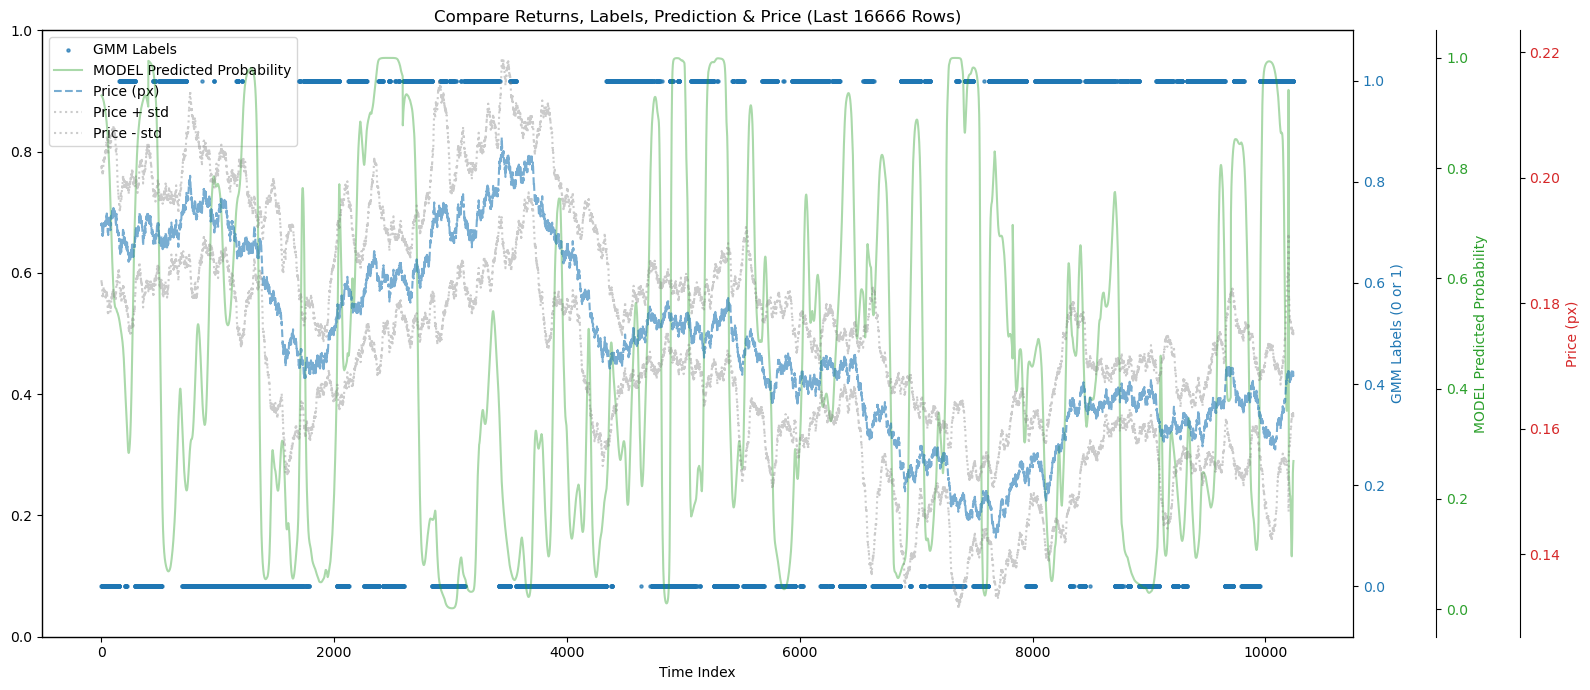

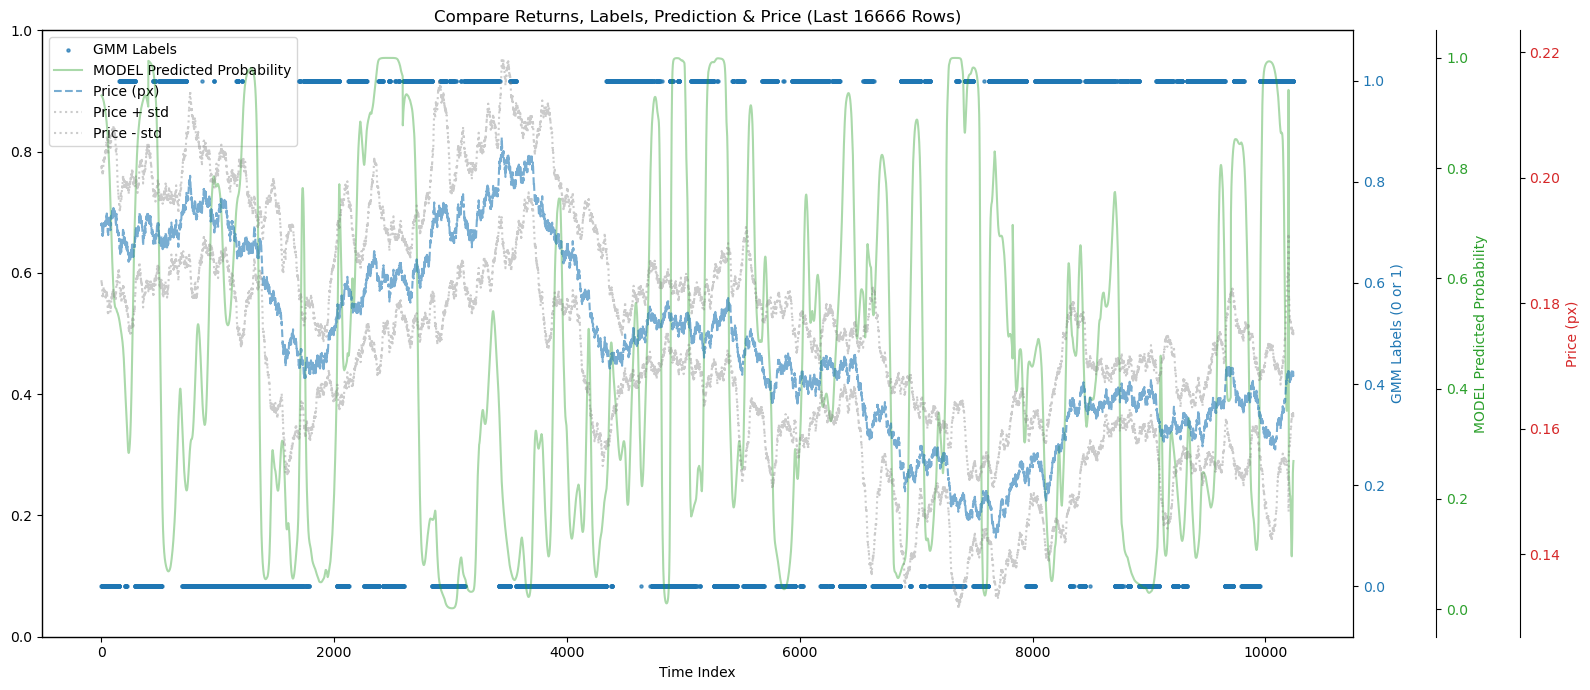

timestamp   symbol  true_label  predicted_prob       px  \
0      1746403300038  BTCUSDT           0        0.364872  0.17074   
1      1746403383232  BTCUSDT           0        0.364946  0.17039   
2      1746403640622  BTCUSDT           0        0.365020  0.17074   
3      1746404534083  BTCUSDT           0        0.365093  0.17109   
4      1746404940940  BTCUSDT           0        0.365165  0.17144   
...              ...      ...         ...             ...      ...   
26904  1751514053610  BTCUSDT           1        0.259602  0.16912   
26905  1751514583925  BTCUSDT           1        0.263391  0.16878   
26906  1751515326766  BTCUSDT           1        0.266366  0.16844   
26907  1751515558320  BTCUSDT           1        0.268716  0.16878   
26908  1751516102398  BTCUSDT           1        0.270587  0.16912   

       rolling_std  predicted_prob_rolling_mean  
0         0.001782                     0.364872  
1         0.001795                     0.364946  
2         0.001805                     0.365020  
3         0.001811                     0.365093  
4         0.001815                     0.365165  
...            ...                          ...  
26904     0.001321                     0.259602  
26905     0.001322                     0.263391  
26906     0.001326                     0.266366  
26907     0.001327                     0.268716  
26908     0.001327                     0.270587  

[26909 rows x 7 columns]

In [25]:
rolling_window_size = 1

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df["true_label"],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.05,
    upper_thresh=0.95,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df["true_label"],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=16666,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df["true_label"], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=16666,
    m=-1, 
    alpha=alpha
)

final_predictions_df


=== model 评估结果 ===
📊 全样本准确率: 0.4532
✅ 自信预测准确率: 0.5356 (阈值 0.1-0.9)
📈 出手率: 14.60%

🧮 自信预测混淆矩阵:
[[1337 1073]
 [ 751  767]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59      2410
           1       0.42      0.51      0.46      1518

    accuracy                           0.54      3928
   macro avg       0.53      0.53      0.53      3928
weighted avg       0.55      0.54      0.54      3928



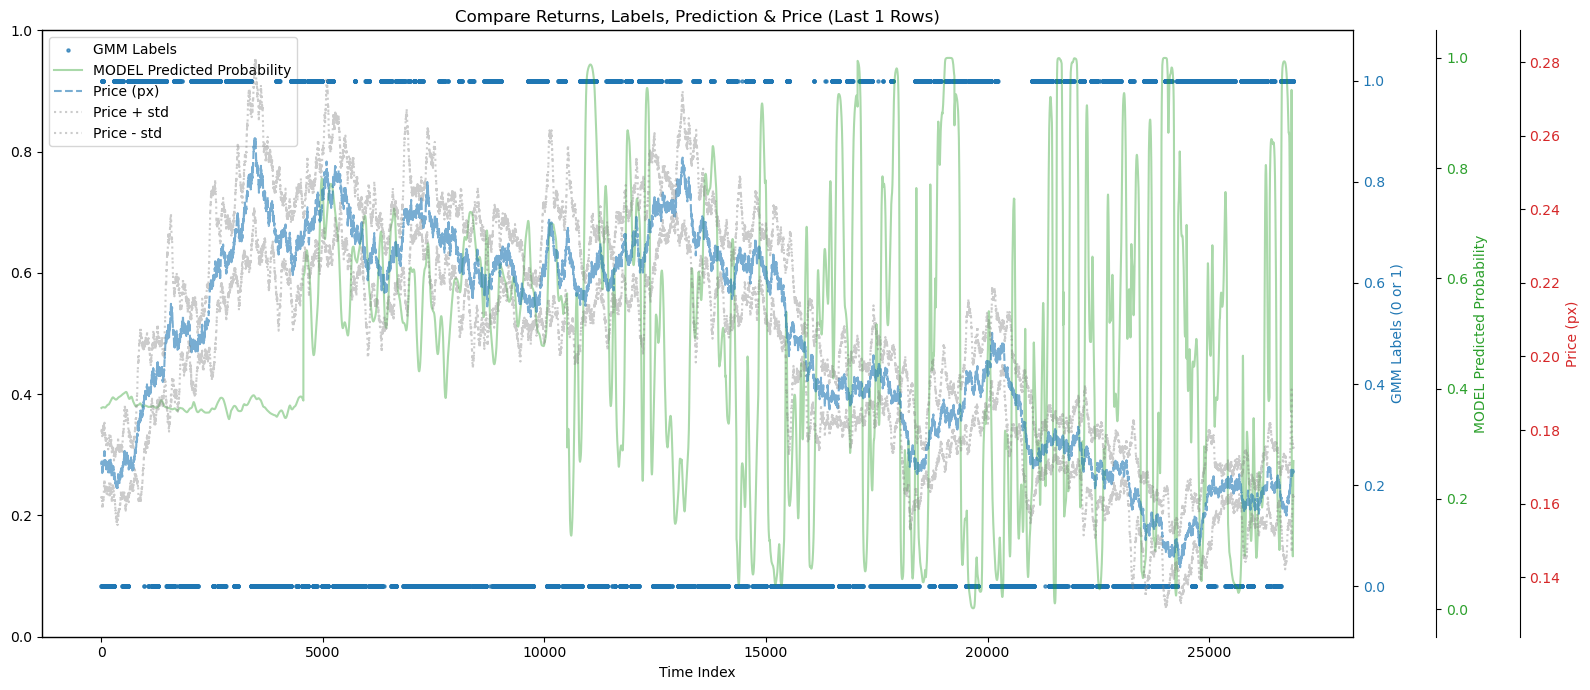

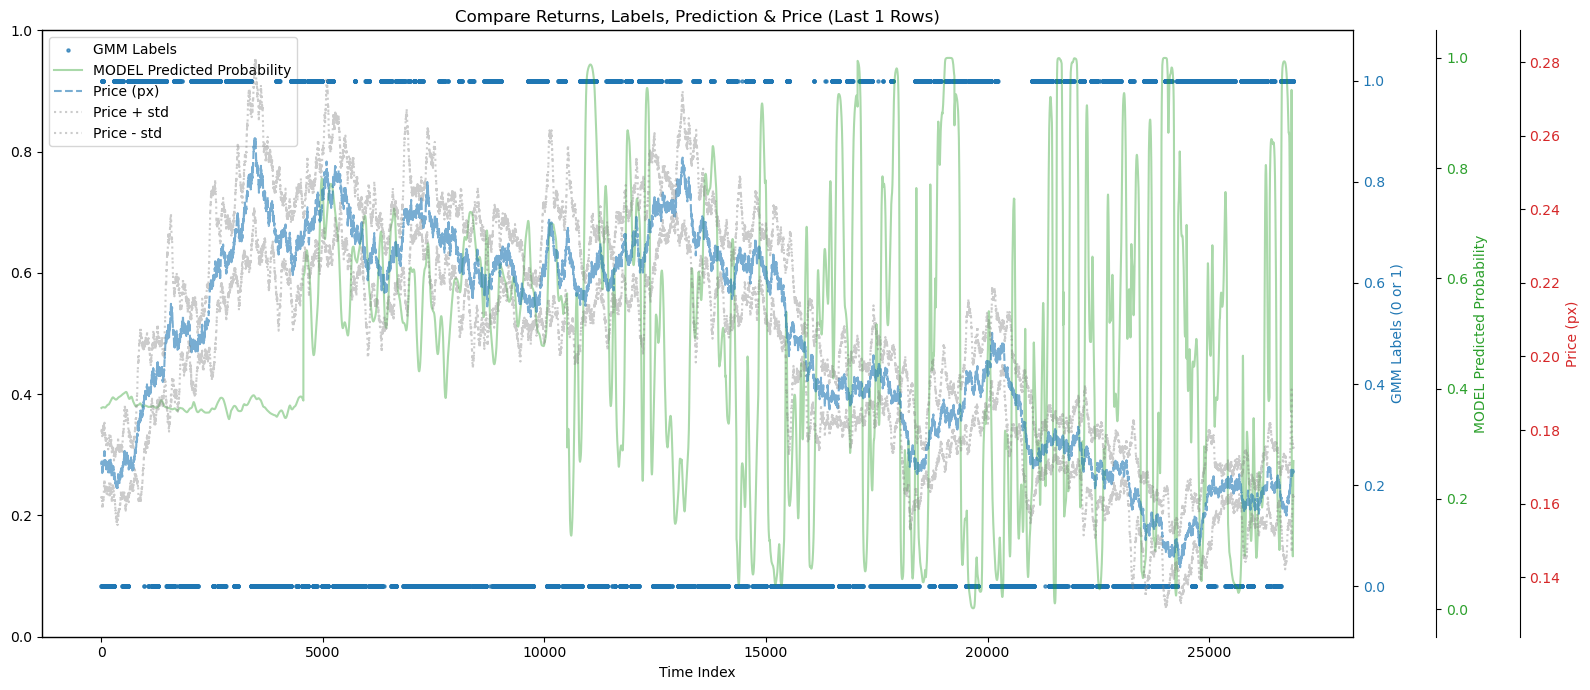

timestamp   symbol  true_label  predicted_prob       px  \
0      1746403300038  BTCUSDT           0        0.364872  0.17074   
1      1746403383232  BTCUSDT           0        0.364946  0.17039   
2      1746403640622  BTCUSDT           0        0.365020  0.17074   
3      1746404534083  BTCUSDT           0        0.365093  0.17109   
4      1746404940940  BTCUSDT           0        0.365165  0.17144   
...              ...      ...         ...             ...      ...   
26904  1751514053610  BTCUSDT           1        0.259602  0.16912   
26905  1751514583925  BTCUSDT           1        0.263391  0.16878   
26906  1751515326766  BTCUSDT           1        0.266366  0.16844   
26907  1751515558320  BTCUSDT           1        0.268716  0.16878   
26908  1751516102398  BTCUSDT           1        0.270587  0.16912   

       rolling_std  predicted_prob_rolling_mean  
0         0.001782                     0.364872  
1         0.001795                     0.364946  
2         0.001805                     0.365020  
3         0.001811                     0.365093  
4         0.001815                     0.365165  
...            ...                          ...  
26904     0.001321                     0.259602  
26905     0.001322                     0.263391  
26906     0.001326                     0.266366  
26907     0.001327                     0.268716  
26908     0.001327                     0.270587  

[26909 rows x 7 columns]

In [26]:
rolling_window_size = 1

final_predictions_df = pd.concat(all_tab_inc_test_predictions).sort_values('timestamp').reset_index(drop=True)

final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

tabnet_eval = evaluate_with_confidence(
    y_true=final_predictions_df["true_label"],
    y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
    model_name="model",
    lower_thresh=0.1,
    upper_thresh=0.9,
    print_report=True,
)

plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df["true_label"],      
    final_predictions_df['predicted_prob_rolling_mean'], 
    final_predictions_df['px'],
    std_array=final_predictions_df['rolling_std'],
    n=1,
    m=-1,
    alpha=alpha,
)
plot_last_n_rows_with_px(
    final_predictions_df['predicted_prob'], 
    final_predictions_df["true_label"], 
    final_predictions_df['predicted_prob'], 
    final_predictions_df['px'], 
    std_array=final_predictions_df['rolling_std'], 
    n=1,
    m=-1, 
    alpha=alpha
)

final_predictions_df

In [27]:
from scipy.stats import spearmanr

signal_col = 'predicted_prob'
return_col = "true_label"

ic_df = final_predictions_df[[signal_col, return_col]].dropna()
rank_ic, p_value = spearmanr(ic_df[signal_col], ic_df[return_col])

print(f"100步 Rank IC: {rank_ic:.4f}, p-value: {p_value:.4g}")


100步 Rank IC: -0.0572, p-value: 6.314e-21


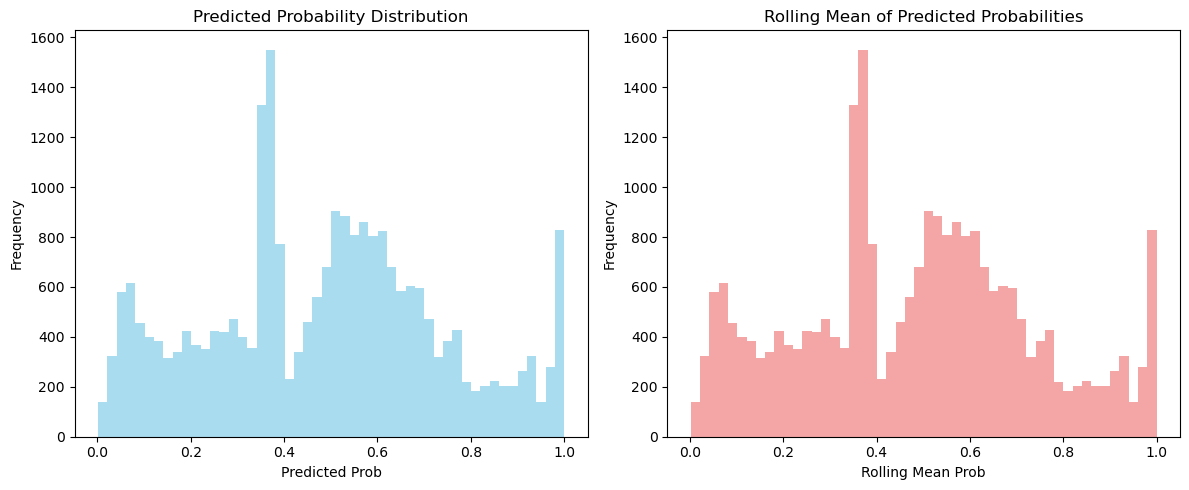

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 原始 predict_proba 分布
plt.subplot(1, 2, 1)
plt.hist(final_predictions_df['predicted_prob'][2000:], bins=50, alpha=0.7, color='skyblue')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Prob')
plt.ylabel('Frequency')

# 滚动均值分布
plt.subplot(1, 2, 2)
plt.hist(final_predictions_df['predicted_prob_rolling_mean'][2000:], bins=50, alpha=0.7, color='lightcoral')
plt.title('Rolling Mean of Predicted Probabilities')
plt.xlabel('Rolling Mean Prob')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 86127.01
Total Return: -13.87%
Total Realized PnL: -14053.14
年化收益 (近似): -60.20%
Maximum Drawdown: -26.15%
Sharpe Ratio (Risk-Free Rate = 0): -257.08
Number of Trades: 96
Win Rate: 43.75%


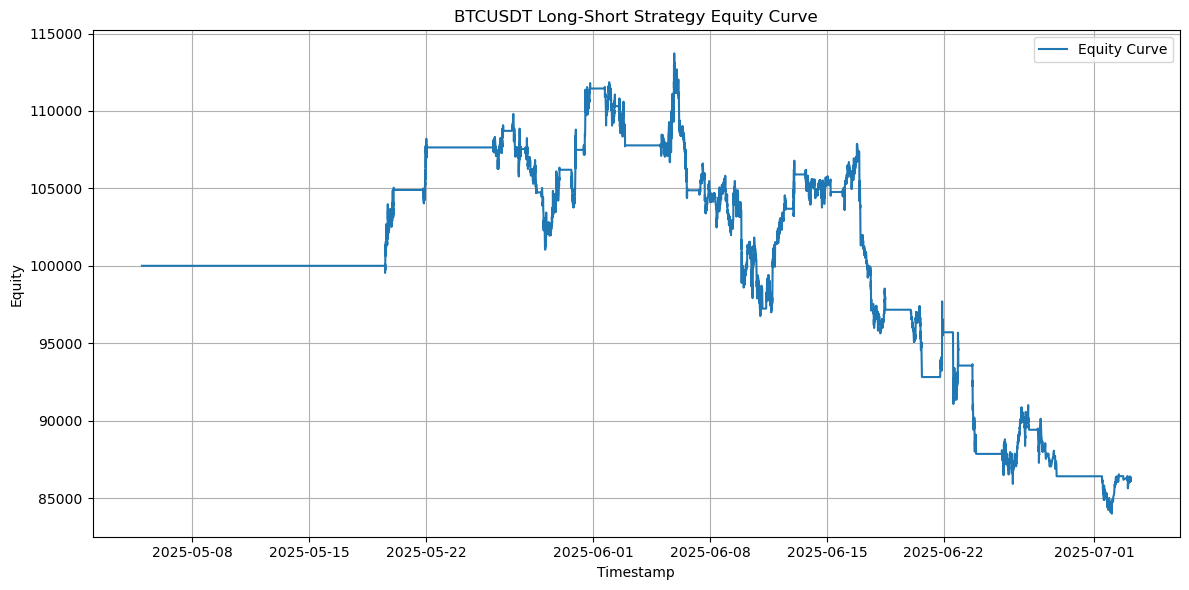

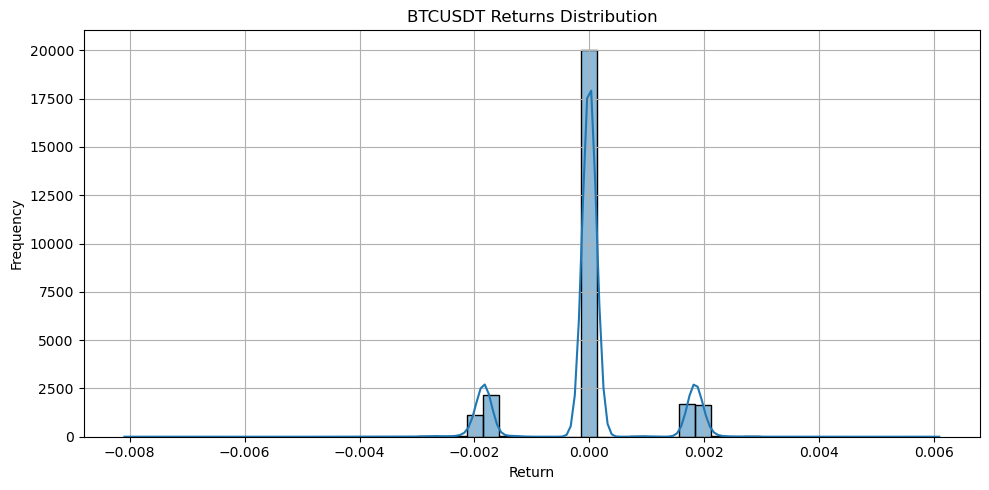

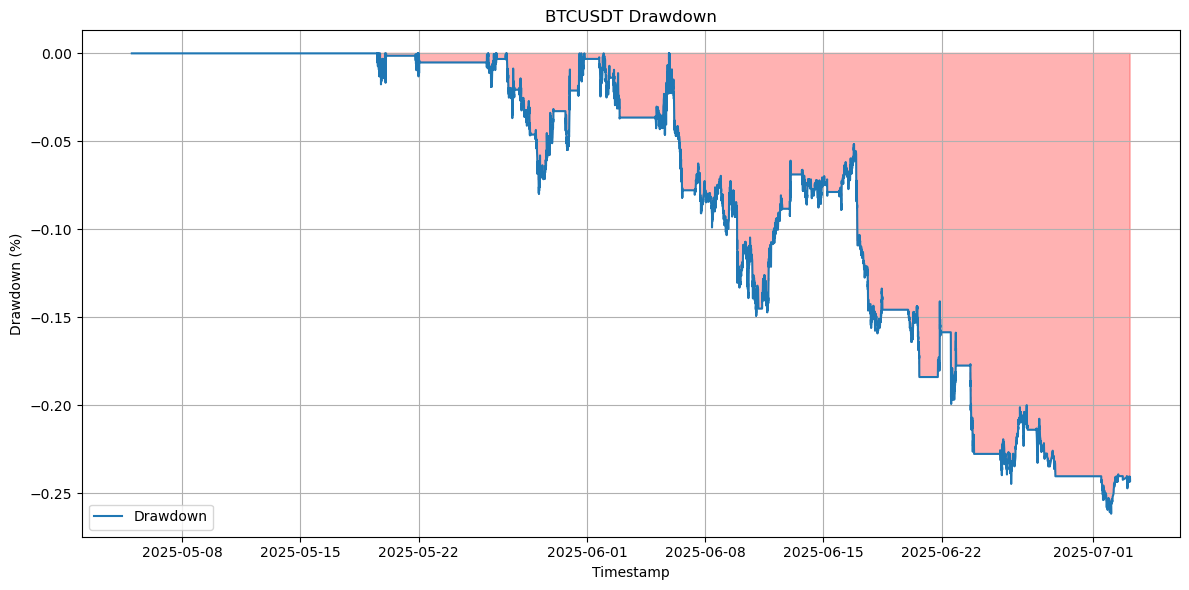

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.9 # Predicted probability above this to go long (buy)
short_threshold = 0.1 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []

a = 0
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        elif a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        elif a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()



Backtesting Results Summary (Long-Short Strategy):
Initial Capital: 100000.00
Final Capital: 86049.03
Total Return: -13.95%
Total Realized PnL: -14278.01
年化收益 (近似): -60.42%
Maximum Drawdown: -28.26%
Sharpe Ratio (Risk-Free Rate = 0): -175.76
Number of Trades: 222
Win Rate: 42.34%


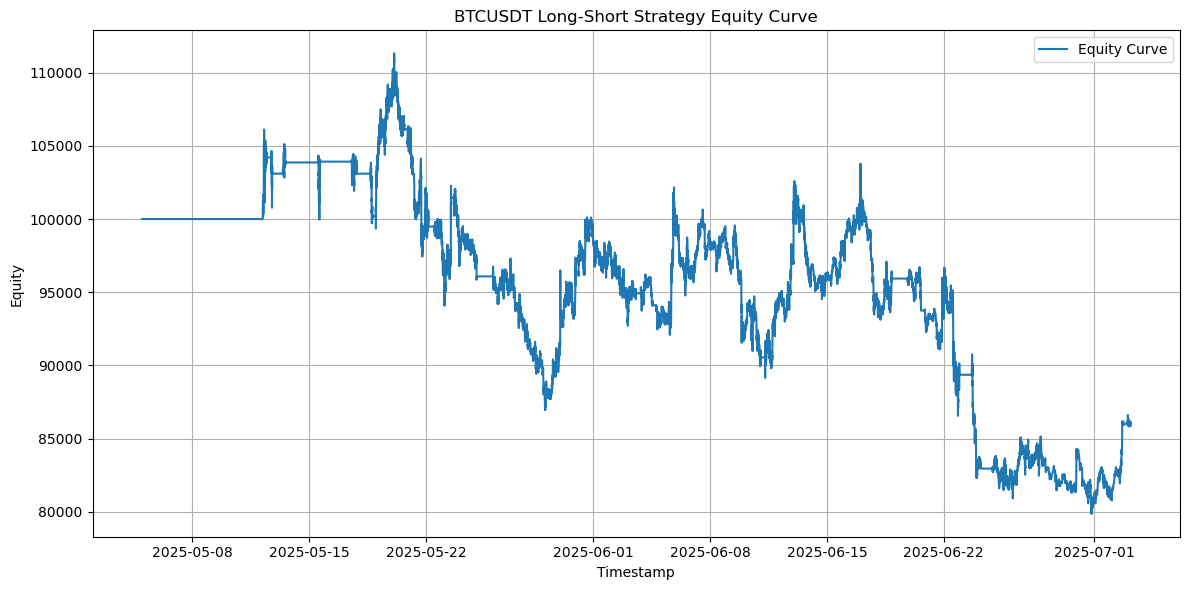

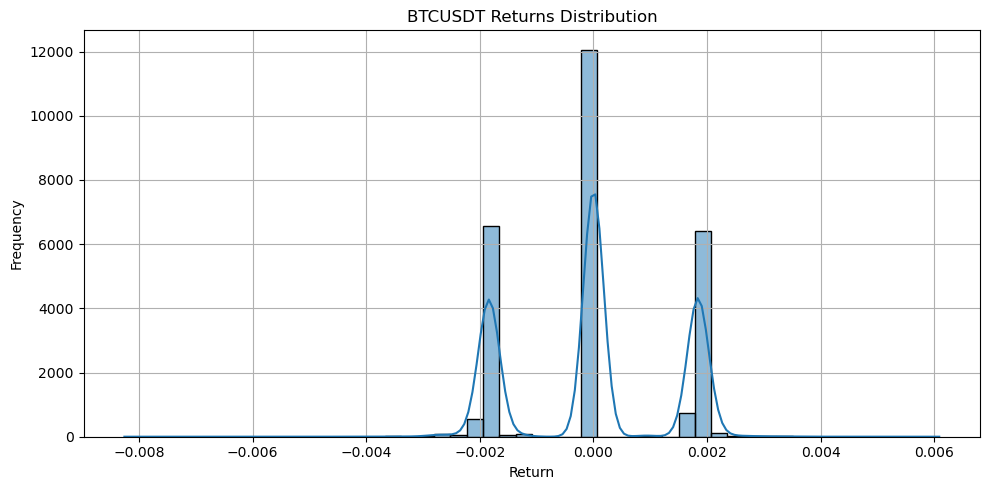

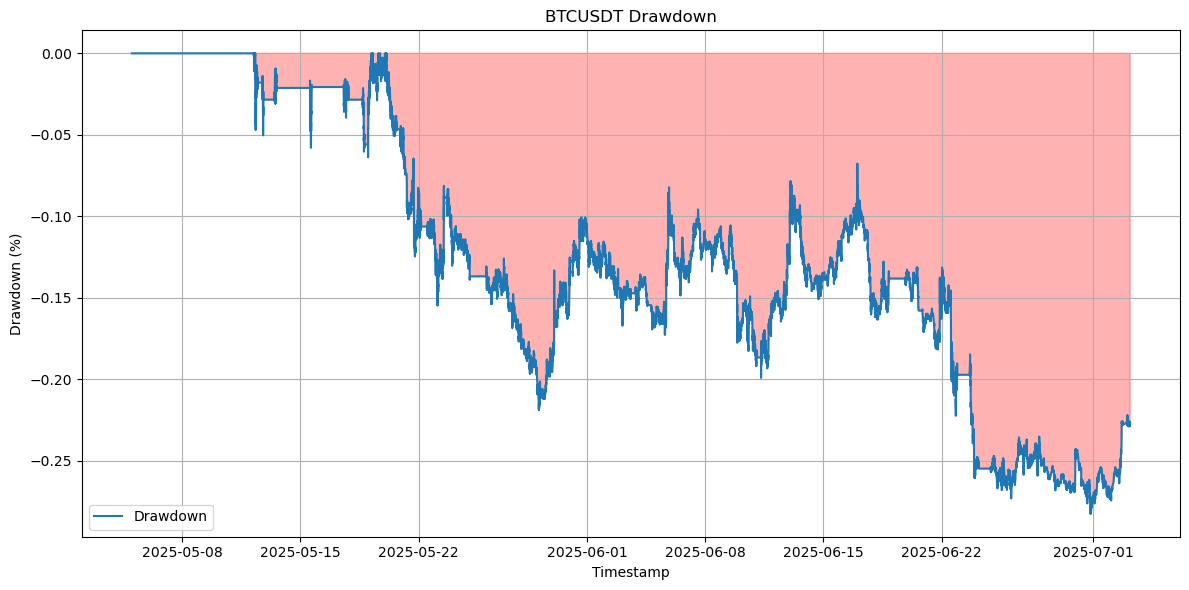

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

all_predictions_df = final_predictions_df
all_predictions_df['timestamp'] = pd.to_datetime(all_predictions_df['timestamp'], unit='ms') # Assuming microseconds

symbol_to_backtest = all_predictions_df['symbol'].iloc[0] # Take the first symbol for now
df = all_predictions_df[all_predictions_df['symbol'] == symbol_to_backtest].copy()
df = df.sort_values('timestamp').reset_index(drop=True)

# ===============================================
# Backtesting Parameters (Ratios for costs)
# ===============================================
initial_capital = 100000  # Initial capital
commission_ratio = 0.0005 # Commission ratio (e.0.05%)
slippage_ratio = 0.001   # Slippage ratio (e.g., 0.02%)

trade_size_ratio = 0.9    # Percentage of current equity to allocate per trade

# Strategy Thresholds (needs optimization)
long_threshold = 0.7 # Predicted probability above this to go long (buy)
short_threshold = 0.3 # Predicted probability below this to go short (sell)

beta = 4
# Dynamic Take Profit / Stop Loss (in multiples of rolling_std/px)
long_stop_loss_multiplier = beta
long_take_profit_multiplier = beta
short_stop_loss_multiplier = beta
short_take_profit_multiplier = beta

# ===============================================
# Backtesting Main Logic (No change here from previous version)
# ===============================================

# Initialize account state
capital = initial_capital
position = 0          # Position size (positive for long, negative for short, 0 for flat)
entry_price = 0       # Entry price for current position
realized_pnl = 0      # Realized PnL from closed trades
equity_curve = [initial_capital] # Equity curve
unrealized_pnl_series = [0]

# Record trades
trades = []
a = 0
for i in range(len(df)):
    current_time = df['timestamp'].iloc[i]
    current_px = df['px'].iloc[i]
    predicted_prob = df['predicted_prob_rolling_mean'].iloc[i]
    current_rolling_std = df['rolling_std'].iloc[i]

    # Calculate current total equity (capital + market value of position)
    if position > 0: # Long position
        unrealized_pnl = (current_px - entry_price) * position
    elif position < 0: # Short position
        unrealized_pnl = (entry_price - current_px) * abs(position) # Profit when price falls
    else: # Flat
        unrealized_pnl = 0

    current_equity = capital + unrealized_pnl
    equity_curve.append(current_equity)
    unrealized_pnl_series.append(unrealized_pnl)

    # -----------------------------------------------
    # Strategy Execution - Long-Short
    # -----------------------------------------------

    # Scenario 1: Currently FLAT (position == 0)
    if position == 0:
        if predicted_prob >= long_threshold: # Go Long Signal
            trade_type = 'BUY_OPEN'
            trade_price = current_px * (1 + slippage_ratio)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = num_shares
                entry_price = trade_price
                # capital -= (position * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

        elif predicted_prob <= short_threshold: # Go Short Signal
            trade_type = 'SELL_SHORT_OPEN'
            trade_price = current_px * (1 - slippage_ratio) # Price for short is lower (sell at market)
            num_shares = (current_equity * trade_size_ratio) / (trade_price * (1 + commission_ratio))

            if num_shares > 0:
                position = -num_shares # Negative for short position
                entry_price = trade_price
                # capital -= (abs(position) * entry_price * (1 + commission_ratio))

                trades.append({
                    'timestamp': current_time, 'type': trade_type, 'price': entry_price, 'shares': position,
                    'capital_after_trade': capital, 'equity_after_trade': current_equity, 'predicted_prob': predicted_prob
                })
                # print(f"{current_time}: {trade_type} {position:.2f} @ {entry_price:.2f} (Prob: {predicted_prob:.4f}) | Capital: {capital:.2f}")

    # Scenario 2: Currently LONG (position > 0)
    elif position > 0:
        a += 1
        sl_price = entry_price - long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price + long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob <= short_threshold: # Changed from sell_threshold to short_threshold for consistent logic
            should_close = True
            reason = "Prediction below short threshold (close long)"
        # if current_px <= sl_price:
        #     should_close = True
        #     reason = "Long Stop Loss Hit"
        # elif current_px >= tp_price:
        #     should_close = True
        #     reason = "Long Take Profit Hit"
        elif a > step:
            should_close = True

        
        if should_close:
            a = 0
            trade_type = 'SELL_CLOSE_LONG'
            close_price = current_px * (1 - slippage_ratio)
            gross_pnl_on_trade = (close_price - entry_price) * position
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * position * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {position:.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0


    # Scenario 3: Currently SHORT (position < 0)
    elif position < 0:
        a += 1
        
        sl_price = entry_price + long_stop_loss_multiplier * current_rolling_std
        tp_price = entry_price - long_take_profit_multiplier * current_rolling_std

        should_close = False
        reason = ""

        if predicted_prob >= long_threshold: # Changed from buy_threshold to long_threshold
            should_close = True
            reason = "Prediction above long threshold (close short)"
            
        # if current_px >= sl_price:
        #     should_close = True
        #     reason = "Short Stop Loss Hit"
        # elif current_px <= tp_price:
        #     should_close = True
        #     reason = "Short Take Profit Hit"
        elif a > step:
            should_close = True
            
        if should_close:
            a = 0
            trade_type = 'BUY_TO_COVER_SHORT'
            close_price = current_px * (1 + slippage_ratio)
            gross_pnl_on_trade = (entry_price - close_price) * abs(position)
            net_pnl_on_trade = gross_pnl_on_trade - (close_price * abs(position) * commission_ratio)

            realized_pnl += net_pnl_on_trade
            capital += net_pnl_on_trade

            trades.append({
                'timestamp': current_time, 'type': trade_type, 'price': close_price, 'shares': position,
                'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': current_equity,
                'reason': reason, 'predicted_prob': predicted_prob
            })
            # print(f"{current_time}: {trade_type} {abs(position):.2f} @ {close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f} | Reason: {reason}")

            position = 0
            entry_price = 0

# Final close-out at the end of backtest if any position is open
final_equity_append_time = df['timestamp'].iloc[-1] + pd.Timedelta(seconds=1)
if position != 0:
    last_px = df['px'].iloc[-1]
    if position > 0: # Close long
        final_close_price = last_px * (1 - slippage_ratio)
        gross_pnl_on_trade = (final_close_price - entry_price) * position
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * position * commission_ratio)
        # capital += (position * final_close_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'SELL_FINAL_LONG', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: SELL_FINAL_LONG {position:.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    else: # Close short
        final_close_price = last_px * (1 + slippage_ratio)
        gross_pnl_on_trade = (entry_price - final_close_price) * abs(position)
        net_pnl_on_trade = gross_pnl_on_trade - (final_close_price * abs(position) * commission_ratio)
        # capital += (abs(position) * entry_price * (1 - commission_ratio))
        trades.append({
            'timestamp': final_equity_append_time, 'type': 'BUY_FINAL_SHORT', 'price': final_close_price, 'shares': position,
            'pnl': net_pnl_on_trade, 'capital_after_trade': capital, 'equity_after_trade': equity_curve[-1],
            'reason': 'End of Backtest', 'predicted_prob': df['predicted_prob'].iloc[-1]
        })
        # print(f"End of Backtest: BUY_FINAL_SHORT {abs(position):.2f} @ {final_close_price:.2f} | PnL: {net_pnl_on_trade:.2f} | Capital: {capital:.2f}")
    realized_pnl += net_pnl_on_trade
    position = 0

# Final equity curve update
equity_curve[-1] = capital
unrealized_pnl_series[-1] = 0
# ===============================================
# Performance Metrics Calculation (KEY CHANGES HERE)
# ===============================================
equity_series = pd.Series(equity_curve, index=df['timestamp'].tolist() + [final_equity_append_time])
returns = equity_series.pct_change().dropna()
unrealized_pnl_series = pd.Series(unrealized_pnl_series, index=equity_series.index)

# Total Return
total_return = (capital - initial_capital) / initial_capital

# Annualized Return - Based on Total Duration
annualized_return = total_return # Default value if not enough data

if len(df) > 1:
    # Get the total duration of the backtest data
    total_duration = df['timestamp'].iloc[-1] - df['timestamp'].iloc[0]
    total_duration_seconds = total_duration.total_seconds()

    if total_duration_seconds > 0:
        # Number of seconds in a year
        seconds_in_year = 365 * 24 * 60 * 60

        # Annualization factor: (seconds in a year) / (total seconds in backtest)
        annualization_factor = seconds_in_year / total_duration_seconds

        # Apply annualization
        annualized_return = (1 + total_return)**annualization_factor - 1
    else:
        print("Warning: Total backtest duration is zero or invalid, cannot annualize return.")
else:
    print("Warning: Not enough data points to calculate total duration for annualization.")


# Max Drawdown
peak = equity_series.expanding(min_periods=1).max()
drawdown = (equity_series - peak) / peak
max_drawdown = drawdown.min()

# Sharpe Ratio (assuming risk-free rate is 0)
# For volatility, we use returns.std() and annualize it with the same factor
annualized_volatility = returns.std() * np.sqrt(annualization_factor) if 'annualization_factor' in locals() and annualization_factor > 0 else returns.std()
sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

# Win Rate for closed trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_closed_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = winning_trades / total_closed_trades if total_closed_trades > 0 else 0
else:
    win_rate = 0


print("\n" + "="*60)
print("Backtesting Results Summary (Long-Short Strategy):")
print(f"Initial Capital: {initial_capital:.2f}")
print(f"Final Capital: {capital:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Total Realized PnL: {realized_pnl:.2f}")
print(f"年化收益 (近似): {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio (Risk-Free Rate = 0): {sharpe_ratio:.2f}")
print(f"Number of Trades: {len(trades)}")
print(f"Win Rate: {win_rate:.2%}")
print("="*60)

# ===============================================
# Plotting
# ===============================================

# Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(equity_series.index, equity_series, label='Equity Curve')
plt.title(f'{symbol_to_backtest} Long-Short Strategy Equity Curve')
plt.xlabel('Timestamp')
plt.ylabel('Equity')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Returns Distribution
if not returns.empty:
    plt.figure(figsize=(10, 5))
    sns.histplot(returns, kde=True, bins=50)
    plt.title(f'{symbol_to_backtest} Returns Distribution')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Drawdown Plot
if not drawdown.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(drawdown.index, drawdown, label='Drawdown')
    plt.fill_between(drawdown.index, drawdown, 0, where=(drawdown < 0), color='red', alpha=0.3)
    plt.title(f'{symbol_to_backtest} Drawdown')
    plt.xlabel('Timestamp')
    plt.ylabel('Drawdown (%)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# plt.figure(figsize=(12, 6))
# plt.plot(unrealized_pnl_series.index, unrealized_pnl_series, label="Unrealized PnL")
# plt.axhline(0, color='gray', linestyle='--')
# plt.title(f"{symbol_to_backtest} 浮动盈亏 (Unrealized PnL)")
# plt.xlabel("Timestamp")
# plt.ylabel("Unrealized PnL")
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()


In [31]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc_future_k",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "feat_cal_window": feat_cal_window,
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lag": feat_trans_lag,
#         "feat_norm_window": feat_norm_window,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         # "label_alpha": alpha,
#         # "label_window": rolling_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "label_step": step,
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#         "bt_ret": total_return,
#         "bt_dd": max_drawdown,
#         "bt_n_trade": len(trades),
#     },
# )

In [32]:
# save_tabnet_checkpoint(
#     model=tab_inc,
#     symbol=symbol,
#     base_save_dir="./saved_models/tabnet_inc",
#     model_params=params,
#     feature_names=X_test.columns,
#     training_meta={
#         "symbol": symbol,
#         "feat_cal_window": feat_cal_window,
#         "feat_trans_window": feat_trans_window,
#         "feat_trans_lag": feat_trans_lag,
#         "feat_norm_window": feat_norm_window,
#         "train_target": file,
#         "train_n_week": n_train_weeks,
#         "class_weight_strategy": "balanced",
#         "init_fit_params": init_fit_params,
#         "inc_fit_params": inc_fit_params,
#         "label_alpha": alpha,
#         "label_window": rolling_window,
#         "fit_start_date": overall_start,
#         "fit_end_date": overall_end,
#         "saved_timestamp": str(pd.Timestamp.now()),
#         "bt_up_thresh": long_threshold,
#         "bt_dn_thresh": short_threshold,
#         "bt_beta": beta,
#     },
# )

In [33]:
# all_df_processed = a_df_filtered.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
# X_all = all_df_processed[feature_cols]
# y_all = all_df_processed[target_col]
# px_all = all_df_processed['px']
# std_all = all_df_processed['rolling_std']
# timestamps_all = all_df_processed['timestamp'] # 收集时间戳

# a = tab_inc.predict_proba(X_train.values)[:, 1]
# print(a)
# all_tab_inc_test_verify = []
# current_window_results = pd.DataFrame({
#     'timestamp': timestamps_all,
#     'symbol': "tst", # 如果有多个股票，收集 symbol 是必要的
#     'true_label': y_all,
#     'predicted_prob': tab_inc.predict_proba(X_all.values)[:, 1],
#     'px': px_all, # 收集价格，回测时需要
#     'rolling_std': std_all # 收集波动率，可能用于策略或分析
#     # 添加任何你回测需要的其他数据
# })
# all_tab_inc_test_verify.append(current_window_results)


In [34]:
# rolling_window_size = 10

# final_predictions_df = pd.concat(all_tab_inc_test_verify).sort_values('timestamp').reset_index(drop=True)

# final_predictions_df['predicted_prob_rolling_mean'] = final_predictions_df['predicted_prob'].rolling(window=rolling_window_size, min_periods=1).mean()

# # tabnet_eval = evaluate_with_confidence(
# #     y_true=final_predictions_df['true_label'],
# #     y_pred_proba=final_predictions_df['predicted_prob_rolling_mean'],
# #     model_name="model",
# #     lower_thresh=0.05,
# #     upper_thresh=0.95,
# #     print_report=True,
# # )

# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['true_label'],      
#     final_predictions_df['predicted_prob_rolling_mean'], 
#     final_predictions_df['px'],
#     std_array=final_predictions_df['rolling_std'],
#     n=1,
#     m=-1,
#     alpha=alpha,
# )
# plot_last_n_rows_with_px(
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['true_label'], 
#     final_predictions_df['predicted_prob'], 
#     final_predictions_df['px'], 
#     std_array=final_predictions_df['rolling_std'], 
#     n=1,
#     m=-1, 
#     alpha=alpha
# )

# final_predictions_df